In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import uniform, randint, shuffle
from NPSmethods2 import readInImages, pupilFunc, getFreq
from numpy.fft import ifftshift, irfft2
import pickle as pkl
import matplotlib.cm as cm
from komm import AWGNChannel
from sklearn.preprocessing import QuantileTransformer, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
#Geranate random assortment of parameters
def make_Paras(seedParasMin, seedParasMax, numToGen):
    outPara = np.empty(shape =(numToGen, len(seedParasMin)))
    paraTemp = [None] * len(seedParasMin)
    for i in range(numToGen):
        for j in range(len(seedParasMin)):
            if j == 5:
                if seedParasMin[j] < 0:
                    low = 1.3
                else:
                    low = 0.77
                if seedParasMax[j] < 0:
                    high = 0.77
                else:
                    high = 1.3
            else:
                low = 1
                high = 1
            para = uniform(seedParasMin[j] * low, seedParasMax[j] * high)
            paraTemp[j] = para
        outPara[i] = paraTemp
    return outPara
        

#Generate M2k_Fit
def make_M2k_Fit(paras, imgSysData):
    
    A, tau, S0, alpha, phi, beta, delta_s = paras
    _, _, K_X, K_Y = getFreq(imgSysData["CCDPixelSize"],
                                      imgSysData["magnification"], (100,100))
    d = imgSysData["wavelen"] / (2*np.pi*imgSysData["NA"])
    R_p, Theta_p = np.abs(K_X + 1j*K_Y) * d, np.angle(K_X + 1j*K_Y)
    p1 = pupilFunc(R_p, Theta_p + np.pi, tau, S0, alpha, phi, beta)
    p2 = np.conj(pupilFunc(R_p, Theta_p, tau, S0, alpha, phi, beta)) * \
            np.exp(-2*1j*delta_s)
    PSF = (p1 + p2) / (2 * np.cos(delta_s))
    M2k = np.abs(PSF)**2
    M2k_Fit = A * M2k
    M2k_Fit[M2k_Fit.shape[0]//2, M2k_Fit.shape[1]//2] = 0
    
    return M2k_Fit

#Function that gets largest values in an array
def Get_Max(array):
    max1 = np.amax(array) * 3
    max2 = np.amax(array[array < max1]) * 3
    
    return array, max1, max2

#Function that mirrors an array with dimensions of odd values
def Mirror(array):
    array2 = np.flip(np.flip(array, 0), 1)
    array2 = np.delete(array2, (0), axis=1)
    newarray = np.concatenate((array, array2), 1)
    
    return newarray

#Turn one NPS to one OD
def NPSavg_To_Single(NPSavgs, numNPSs):
    NPSs = []
    
    #Reduce dimensions down to 49x49 image
    NPSavgs = np.delete(NPSavgs, np.s_[75:100], axis = 1)
    NPSavgs = np.delete(NPSavgs, np.s_[0:26], axis = 1)
    NPSavgs = np.delete(NPSavgs, np.s_[75:100], axis = 2)
    NPSavgs = np.delete(NPSavgs, np.s_[0:26], axis = 2)

    
    for count, NPSavg in enumerate(NPSavgs):
        print("Parameters Set: %d" % (count + 1))
        for i in range(numNPSs):
            NPStemp = NPSavg.copy()
            NPStemp[NPStemp < 0] = 0 #Truncate at 0
            NSR = np.random.exponential(scale=1.1, size=(49,25))**1.1 - 1 #Noise to signal ratio
            NSR[NSR < -1] = -1
            NSR, max1, max2 = Get_Max(NSR) #Get the maximum values for noise to signal ratio
            NSR = Mirror(NSR) #Mirror the noise to signal ratio
            Scale = np.random.randint(19,55) / 1000
            Bkg = np.random.exponential(scale=Scale, size=(49,25)) #Generate background noise
            Bkg[Bkg < 0] = 0
            Bkg = Mirror(Bkg) #Mirror the background noise
            
            randc = randint(1,3) // 3 #Randomly select brightness of pixels that make a plus sign around center (noise feature)
            randx = randint(1,3) // 2 #Randomly determine whether the image has a horizontal line noise feature
            randy = randint(1,3) // 2 #Randomly determine whether the image has a vertical line noise feature
            
            mean = np.mean(NPStemp) #Mean value for the array used in creating noise features
            amax = np.amax(NPStemp) #Maximum value for the array used in creating noise features
            mean_bkg = np.mean(Bkg) #Mean value of the photon shot noise used in creating noise features
            
            for j in range(len(NPStemp)):
                for k in range(len(NPStemp.T)):
                    if (NPSavg[j][k] == 0):#Add background noise
                        NPStemp[j][k] += Bkg[j][k]
                    else:
                        NPStemp[j][k] += mean_bkg
#                     NPStemp[j][k] += mean_bkg
                    if ((j == 23 or j == 25) and k == 24): #Add center bright points
                        if randc == 1:
                            NPStemp[j][k] = mean + mean * (max2) 
                        else :
                            NPStemp[j][k] = amax + amax * (max1)
                    elif (j == 24 and (k == 23 or k == 25)): #Add center bright points
                        if randc == 1:
                            NPStemp[j][k] = amax + amax * (max1)
                        else:
                            NPStemp[j][k] = mean + mean * (max2)
                    elif (NPSavg[j][k] != 0): #Add noise scaled by noise to signal ratio
                        NPStemp[j][k] += NPStemp[j][k] * NSR[j][k]
                    if j == 24: #Add horizontal and vertial lines
                        NPStemp[j][k] += .5 * mean * randx 
                    if k == 24:
                        NPStemp[j][k] += .5 * mean * randy
            NPStemp[24][24] = 0 #Zero the center dot
            NPStemp[NPStemp < 0] = 0 #Floor negative values to 0
            NPSs.append(NPStemp)
            
    return np.array(NPSs)

In [3]:
savepath = './results/' #Savepath for images and parameters

numNPSs = 2 #Number of NPS images to make for each parameter set
numParas = 25000 #Number of parameter sets to generate

#Import minimum and maximum seed parameters
seedParasMax = pkl.load(open(savepath + "seedParasMax.pkl", "rb"))
seedParasMin = pkl.load(open(savepath + "seedParasMin.pkl", "rb"))

NPSavgs = np.empty((numParas,100,100))
fakeNPSs = np.empty((numNPSs*numParas,49,49))
savedParas = []

imgSysData = { 
    "CCDPixelSize": 13,      # pixel size of the CCD, in micron 
    "magnification": 27,      # 799.943 / 29.9099, # magnification of the imaging system 
    "wavelen"     : 0.852,     # wavelength of the imaging beam, in micron 
    "NA"          : 0.37,      # numerical aperture of the objective 
    "ODtoAtom"    : 13
} 

#Create image and parameter arrays
for i, paras in enumerate(make_Paras(seedParasMin, seedParasMax, numParas)):
    if (i + 1) % 1000 == 0:
        print(i + 1)
    NPSavgs[i] = make_M2k_Fit(paras, imgSysData)
    for j in range(numNPSs):
        savedParas.append(paras)
fakeNPSs = NPSavg_To_Single(NPSavgs, numNPSs)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Parameters Set: 1
Parameters Set: 2
Parameters Set: 3
Parameters Set: 4
Parameters Set: 5
Parameters Set: 6
Parameters Set: 7
Parameters Set: 8
Parameters Set: 9
Parameters Set: 10
Parameters Set: 11
Parameters Set: 12
Parameters Set: 13
Parameters Set: 14
Parameters Set: 15
Parameters Set: 16
Parameters Set: 17
Parameters Set: 18
Parameters Set: 19
Parameters Set: 20
Parameters Set: 21
Parameters Set: 22
Parameters Set: 23
Parameters Set: 24
Parameters Set: 25
Parameters Set: 26
Parameters Set: 27
Parameters Set: 28
Parameters Set: 29
Parameters Set: 30
Parameters Set: 31
Parameters Set: 32
Parameters Set: 33
Parameters Set: 34
Parameters Set: 35
Parameters Set: 36
Parameters Set: 37
Parameters Set: 38
Parameters Set: 39
Parameters Set: 40
Parameters Set: 41
Parameters Set: 42
Parameters Set: 43
Parameters Set: 44
Parameters Set: 45
Parameters Se

Parameters Set: 416
Parameters Set: 417
Parameters Set: 418
Parameters Set: 419
Parameters Set: 420
Parameters Set: 421
Parameters Set: 422
Parameters Set: 423
Parameters Set: 424
Parameters Set: 425
Parameters Set: 426
Parameters Set: 427
Parameters Set: 428
Parameters Set: 429
Parameters Set: 430
Parameters Set: 431
Parameters Set: 432
Parameters Set: 433
Parameters Set: 434
Parameters Set: 435
Parameters Set: 436
Parameters Set: 437
Parameters Set: 438
Parameters Set: 439
Parameters Set: 440
Parameters Set: 441
Parameters Set: 442
Parameters Set: 443
Parameters Set: 444
Parameters Set: 445
Parameters Set: 446
Parameters Set: 447
Parameters Set: 448
Parameters Set: 449
Parameters Set: 450
Parameters Set: 451
Parameters Set: 452
Parameters Set: 453
Parameters Set: 454
Parameters Set: 455
Parameters Set: 456
Parameters Set: 457
Parameters Set: 458
Parameters Set: 459
Parameters Set: 460
Parameters Set: 461
Parameters Set: 462
Parameters Set: 463
Parameters Set: 464
Parameters Set: 465


Parameters Set: 834
Parameters Set: 835
Parameters Set: 836
Parameters Set: 837
Parameters Set: 838
Parameters Set: 839
Parameters Set: 840
Parameters Set: 841
Parameters Set: 842
Parameters Set: 843
Parameters Set: 844
Parameters Set: 845
Parameters Set: 846
Parameters Set: 847
Parameters Set: 848
Parameters Set: 849
Parameters Set: 850
Parameters Set: 851
Parameters Set: 852
Parameters Set: 853
Parameters Set: 854
Parameters Set: 855
Parameters Set: 856
Parameters Set: 857
Parameters Set: 858
Parameters Set: 859
Parameters Set: 860
Parameters Set: 861
Parameters Set: 862
Parameters Set: 863
Parameters Set: 864
Parameters Set: 865
Parameters Set: 866
Parameters Set: 867
Parameters Set: 868
Parameters Set: 869
Parameters Set: 870
Parameters Set: 871
Parameters Set: 872
Parameters Set: 873
Parameters Set: 874
Parameters Set: 875
Parameters Set: 876
Parameters Set: 877
Parameters Set: 878
Parameters Set: 879
Parameters Set: 880
Parameters Set: 881
Parameters Set: 882
Parameters Set: 883


Parameters Set: 1238
Parameters Set: 1239
Parameters Set: 1240
Parameters Set: 1241
Parameters Set: 1242
Parameters Set: 1243
Parameters Set: 1244
Parameters Set: 1245
Parameters Set: 1246
Parameters Set: 1247
Parameters Set: 1248
Parameters Set: 1249
Parameters Set: 1250
Parameters Set: 1251
Parameters Set: 1252
Parameters Set: 1253
Parameters Set: 1254
Parameters Set: 1255
Parameters Set: 1256
Parameters Set: 1257
Parameters Set: 1258
Parameters Set: 1259
Parameters Set: 1260
Parameters Set: 1261
Parameters Set: 1262
Parameters Set: 1263
Parameters Set: 1264
Parameters Set: 1265
Parameters Set: 1266
Parameters Set: 1267
Parameters Set: 1268
Parameters Set: 1269
Parameters Set: 1270
Parameters Set: 1271
Parameters Set: 1272
Parameters Set: 1273
Parameters Set: 1274
Parameters Set: 1275
Parameters Set: 1276
Parameters Set: 1277
Parameters Set: 1278
Parameters Set: 1279
Parameters Set: 1280
Parameters Set: 1281
Parameters Set: 1282
Parameters Set: 1283
Parameters Set: 1284
Parameters Se

Parameters Set: 1631
Parameters Set: 1632
Parameters Set: 1633
Parameters Set: 1634
Parameters Set: 1635
Parameters Set: 1636
Parameters Set: 1637
Parameters Set: 1638
Parameters Set: 1639
Parameters Set: 1640
Parameters Set: 1641
Parameters Set: 1642
Parameters Set: 1643
Parameters Set: 1644
Parameters Set: 1645
Parameters Set: 1646
Parameters Set: 1647
Parameters Set: 1648
Parameters Set: 1649
Parameters Set: 1650
Parameters Set: 1651
Parameters Set: 1652
Parameters Set: 1653
Parameters Set: 1654
Parameters Set: 1655
Parameters Set: 1656
Parameters Set: 1657
Parameters Set: 1658
Parameters Set: 1659
Parameters Set: 1660
Parameters Set: 1661
Parameters Set: 1662
Parameters Set: 1663
Parameters Set: 1664
Parameters Set: 1665
Parameters Set: 1666
Parameters Set: 1667
Parameters Set: 1668
Parameters Set: 1669
Parameters Set: 1670
Parameters Set: 1671
Parameters Set: 1672
Parameters Set: 1673
Parameters Set: 1674
Parameters Set: 1675
Parameters Set: 1676
Parameters Set: 1677
Parameters Se

Parameters Set: 2025
Parameters Set: 2026
Parameters Set: 2027
Parameters Set: 2028
Parameters Set: 2029
Parameters Set: 2030
Parameters Set: 2031
Parameters Set: 2032
Parameters Set: 2033
Parameters Set: 2034
Parameters Set: 2035
Parameters Set: 2036
Parameters Set: 2037
Parameters Set: 2038
Parameters Set: 2039
Parameters Set: 2040
Parameters Set: 2041
Parameters Set: 2042
Parameters Set: 2043
Parameters Set: 2044
Parameters Set: 2045
Parameters Set: 2046
Parameters Set: 2047
Parameters Set: 2048
Parameters Set: 2049
Parameters Set: 2050
Parameters Set: 2051
Parameters Set: 2052
Parameters Set: 2053
Parameters Set: 2054
Parameters Set: 2055
Parameters Set: 2056
Parameters Set: 2057
Parameters Set: 2058
Parameters Set: 2059
Parameters Set: 2060
Parameters Set: 2061
Parameters Set: 2062
Parameters Set: 2063
Parameters Set: 2064
Parameters Set: 2065
Parameters Set: 2066
Parameters Set: 2067
Parameters Set: 2068
Parameters Set: 2069
Parameters Set: 2070
Parameters Set: 2071
Parameters Se

Parameters Set: 2427
Parameters Set: 2428
Parameters Set: 2429
Parameters Set: 2430
Parameters Set: 2431
Parameters Set: 2432
Parameters Set: 2433
Parameters Set: 2434
Parameters Set: 2435
Parameters Set: 2436
Parameters Set: 2437
Parameters Set: 2438
Parameters Set: 2439
Parameters Set: 2440
Parameters Set: 2441
Parameters Set: 2442
Parameters Set: 2443
Parameters Set: 2444
Parameters Set: 2445
Parameters Set: 2446
Parameters Set: 2447
Parameters Set: 2448
Parameters Set: 2449
Parameters Set: 2450
Parameters Set: 2451
Parameters Set: 2452
Parameters Set: 2453
Parameters Set: 2454
Parameters Set: 2455
Parameters Set: 2456
Parameters Set: 2457
Parameters Set: 2458
Parameters Set: 2459
Parameters Set: 2460
Parameters Set: 2461
Parameters Set: 2462
Parameters Set: 2463
Parameters Set: 2464
Parameters Set: 2465
Parameters Set: 2466
Parameters Set: 2467
Parameters Set: 2468
Parameters Set: 2469
Parameters Set: 2470
Parameters Set: 2471
Parameters Set: 2472
Parameters Set: 2473
Parameters Se

Parameters Set: 2829
Parameters Set: 2830
Parameters Set: 2831
Parameters Set: 2832
Parameters Set: 2833
Parameters Set: 2834
Parameters Set: 2835
Parameters Set: 2836
Parameters Set: 2837
Parameters Set: 2838
Parameters Set: 2839
Parameters Set: 2840
Parameters Set: 2841
Parameters Set: 2842
Parameters Set: 2843
Parameters Set: 2844
Parameters Set: 2845
Parameters Set: 2846
Parameters Set: 2847
Parameters Set: 2848
Parameters Set: 2849
Parameters Set: 2850
Parameters Set: 2851
Parameters Set: 2852
Parameters Set: 2853
Parameters Set: 2854
Parameters Set: 2855
Parameters Set: 2856
Parameters Set: 2857
Parameters Set: 2858
Parameters Set: 2859
Parameters Set: 2860
Parameters Set: 2861
Parameters Set: 2862
Parameters Set: 2863
Parameters Set: 2864
Parameters Set: 2865
Parameters Set: 2866
Parameters Set: 2867
Parameters Set: 2868
Parameters Set: 2869
Parameters Set: 2870
Parameters Set: 2871
Parameters Set: 2872
Parameters Set: 2873
Parameters Set: 2874
Parameters Set: 2875
Parameters Se

Parameters Set: 3234
Parameters Set: 3235
Parameters Set: 3236
Parameters Set: 3237
Parameters Set: 3238
Parameters Set: 3239
Parameters Set: 3240
Parameters Set: 3241
Parameters Set: 3242
Parameters Set: 3243
Parameters Set: 3244
Parameters Set: 3245
Parameters Set: 3246
Parameters Set: 3247
Parameters Set: 3248
Parameters Set: 3249
Parameters Set: 3250
Parameters Set: 3251
Parameters Set: 3252
Parameters Set: 3253
Parameters Set: 3254
Parameters Set: 3255
Parameters Set: 3256
Parameters Set: 3257
Parameters Set: 3258
Parameters Set: 3259
Parameters Set: 3260
Parameters Set: 3261
Parameters Set: 3262
Parameters Set: 3263
Parameters Set: 3264
Parameters Set: 3265
Parameters Set: 3266
Parameters Set: 3267
Parameters Set: 3268
Parameters Set: 3269
Parameters Set: 3270
Parameters Set: 3271
Parameters Set: 3272
Parameters Set: 3273
Parameters Set: 3274
Parameters Set: 3275
Parameters Set: 3276
Parameters Set: 3277
Parameters Set: 3278
Parameters Set: 3279
Parameters Set: 3280
Parameters Se

Parameters Set: 3635
Parameters Set: 3636
Parameters Set: 3637
Parameters Set: 3638
Parameters Set: 3639
Parameters Set: 3640
Parameters Set: 3641
Parameters Set: 3642
Parameters Set: 3643
Parameters Set: 3644
Parameters Set: 3645
Parameters Set: 3646
Parameters Set: 3647
Parameters Set: 3648
Parameters Set: 3649
Parameters Set: 3650
Parameters Set: 3651
Parameters Set: 3652
Parameters Set: 3653
Parameters Set: 3654
Parameters Set: 3655
Parameters Set: 3656
Parameters Set: 3657
Parameters Set: 3658
Parameters Set: 3659
Parameters Set: 3660
Parameters Set: 3661
Parameters Set: 3662
Parameters Set: 3663
Parameters Set: 3664
Parameters Set: 3665
Parameters Set: 3666
Parameters Set: 3667
Parameters Set: 3668
Parameters Set: 3669
Parameters Set: 3670
Parameters Set: 3671
Parameters Set: 3672
Parameters Set: 3673
Parameters Set: 3674
Parameters Set: 3675
Parameters Set: 3676
Parameters Set: 3677
Parameters Set: 3678
Parameters Set: 3679
Parameters Set: 3680
Parameters Set: 3681
Parameters Se

Parameters Set: 4033
Parameters Set: 4034
Parameters Set: 4035
Parameters Set: 4036
Parameters Set: 4037
Parameters Set: 4038
Parameters Set: 4039
Parameters Set: 4040
Parameters Set: 4041
Parameters Set: 4042
Parameters Set: 4043
Parameters Set: 4044
Parameters Set: 4045
Parameters Set: 4046
Parameters Set: 4047
Parameters Set: 4048
Parameters Set: 4049
Parameters Set: 4050
Parameters Set: 4051
Parameters Set: 4052
Parameters Set: 4053
Parameters Set: 4054
Parameters Set: 4055
Parameters Set: 4056
Parameters Set: 4057
Parameters Set: 4058
Parameters Set: 4059
Parameters Set: 4060
Parameters Set: 4061
Parameters Set: 4062
Parameters Set: 4063
Parameters Set: 4064
Parameters Set: 4065
Parameters Set: 4066
Parameters Set: 4067
Parameters Set: 4068
Parameters Set: 4069
Parameters Set: 4070
Parameters Set: 4071
Parameters Set: 4072
Parameters Set: 4073
Parameters Set: 4074
Parameters Set: 4075
Parameters Set: 4076
Parameters Set: 4077
Parameters Set: 4078
Parameters Set: 4079
Parameters Se

Parameters Set: 4426
Parameters Set: 4427
Parameters Set: 4428
Parameters Set: 4429
Parameters Set: 4430
Parameters Set: 4431
Parameters Set: 4432
Parameters Set: 4433
Parameters Set: 4434
Parameters Set: 4435
Parameters Set: 4436
Parameters Set: 4437
Parameters Set: 4438
Parameters Set: 4439
Parameters Set: 4440
Parameters Set: 4441
Parameters Set: 4442
Parameters Set: 4443
Parameters Set: 4444
Parameters Set: 4445
Parameters Set: 4446
Parameters Set: 4447
Parameters Set: 4448
Parameters Set: 4449
Parameters Set: 4450
Parameters Set: 4451
Parameters Set: 4452
Parameters Set: 4453
Parameters Set: 4454
Parameters Set: 4455
Parameters Set: 4456
Parameters Set: 4457
Parameters Set: 4458
Parameters Set: 4459
Parameters Set: 4460
Parameters Set: 4461
Parameters Set: 4462
Parameters Set: 4463
Parameters Set: 4464
Parameters Set: 4465
Parameters Set: 4466
Parameters Set: 4467
Parameters Set: 4468
Parameters Set: 4469
Parameters Set: 4470
Parameters Set: 4471
Parameters Set: 4472
Parameters Se

Parameters Set: 4822
Parameters Set: 4823
Parameters Set: 4824
Parameters Set: 4825
Parameters Set: 4826
Parameters Set: 4827
Parameters Set: 4828
Parameters Set: 4829
Parameters Set: 4830
Parameters Set: 4831
Parameters Set: 4832
Parameters Set: 4833
Parameters Set: 4834
Parameters Set: 4835
Parameters Set: 4836
Parameters Set: 4837
Parameters Set: 4838
Parameters Set: 4839
Parameters Set: 4840
Parameters Set: 4841
Parameters Set: 4842
Parameters Set: 4843
Parameters Set: 4844
Parameters Set: 4845
Parameters Set: 4846
Parameters Set: 4847
Parameters Set: 4848
Parameters Set: 4849
Parameters Set: 4850
Parameters Set: 4851
Parameters Set: 4852
Parameters Set: 4853
Parameters Set: 4854
Parameters Set: 4855
Parameters Set: 4856
Parameters Set: 4857
Parameters Set: 4858
Parameters Set: 4859
Parameters Set: 4860
Parameters Set: 4861
Parameters Set: 4862
Parameters Set: 4863
Parameters Set: 4864
Parameters Set: 4865
Parameters Set: 4866
Parameters Set: 4867
Parameters Set: 4868
Parameters Se

Parameters Set: 5220
Parameters Set: 5221
Parameters Set: 5222
Parameters Set: 5223
Parameters Set: 5224
Parameters Set: 5225
Parameters Set: 5226
Parameters Set: 5227
Parameters Set: 5228
Parameters Set: 5229
Parameters Set: 5230
Parameters Set: 5231
Parameters Set: 5232
Parameters Set: 5233
Parameters Set: 5234
Parameters Set: 5235
Parameters Set: 5236
Parameters Set: 5237
Parameters Set: 5238
Parameters Set: 5239
Parameters Set: 5240
Parameters Set: 5241
Parameters Set: 5242
Parameters Set: 5243
Parameters Set: 5244
Parameters Set: 5245
Parameters Set: 5246
Parameters Set: 5247
Parameters Set: 5248
Parameters Set: 5249
Parameters Set: 5250
Parameters Set: 5251
Parameters Set: 5252
Parameters Set: 5253
Parameters Set: 5254
Parameters Set: 5255
Parameters Set: 5256
Parameters Set: 5257
Parameters Set: 5258
Parameters Set: 5259
Parameters Set: 5260
Parameters Set: 5261
Parameters Set: 5262
Parameters Set: 5263
Parameters Set: 5264
Parameters Set: 5265
Parameters Set: 5266
Parameters Se

Parameters Set: 5628
Parameters Set: 5629
Parameters Set: 5630
Parameters Set: 5631
Parameters Set: 5632
Parameters Set: 5633
Parameters Set: 5634
Parameters Set: 5635
Parameters Set: 5636
Parameters Set: 5637
Parameters Set: 5638
Parameters Set: 5639
Parameters Set: 5640
Parameters Set: 5641
Parameters Set: 5642
Parameters Set: 5643
Parameters Set: 5644
Parameters Set: 5645
Parameters Set: 5646
Parameters Set: 5647
Parameters Set: 5648
Parameters Set: 5649
Parameters Set: 5650
Parameters Set: 5651
Parameters Set: 5652
Parameters Set: 5653
Parameters Set: 5654
Parameters Set: 5655
Parameters Set: 5656
Parameters Set: 5657
Parameters Set: 5658
Parameters Set: 5659
Parameters Set: 5660
Parameters Set: 5661
Parameters Set: 5662
Parameters Set: 5663
Parameters Set: 5664
Parameters Set: 5665
Parameters Set: 5666
Parameters Set: 5667
Parameters Set: 5668
Parameters Set: 5669
Parameters Set: 5670
Parameters Set: 5671
Parameters Set: 5672
Parameters Set: 5673
Parameters Set: 5674
Parameters Se

Parameters Set: 6027
Parameters Set: 6028
Parameters Set: 6029
Parameters Set: 6030
Parameters Set: 6031
Parameters Set: 6032
Parameters Set: 6033
Parameters Set: 6034
Parameters Set: 6035
Parameters Set: 6036
Parameters Set: 6037
Parameters Set: 6038
Parameters Set: 6039
Parameters Set: 6040
Parameters Set: 6041
Parameters Set: 6042
Parameters Set: 6043
Parameters Set: 6044
Parameters Set: 6045
Parameters Set: 6046
Parameters Set: 6047
Parameters Set: 6048
Parameters Set: 6049
Parameters Set: 6050
Parameters Set: 6051
Parameters Set: 6052
Parameters Set: 6053
Parameters Set: 6054
Parameters Set: 6055
Parameters Set: 6056
Parameters Set: 6057
Parameters Set: 6058
Parameters Set: 6059
Parameters Set: 6060
Parameters Set: 6061
Parameters Set: 6062
Parameters Set: 6063
Parameters Set: 6064
Parameters Set: 6065
Parameters Set: 6066
Parameters Set: 6067
Parameters Set: 6068
Parameters Set: 6069
Parameters Set: 6070
Parameters Set: 6071
Parameters Set: 6072
Parameters Set: 6073
Parameters Se

Parameters Set: 6419
Parameters Set: 6420
Parameters Set: 6421
Parameters Set: 6422
Parameters Set: 6423
Parameters Set: 6424
Parameters Set: 6425
Parameters Set: 6426
Parameters Set: 6427
Parameters Set: 6428
Parameters Set: 6429
Parameters Set: 6430
Parameters Set: 6431
Parameters Set: 6432
Parameters Set: 6433
Parameters Set: 6434
Parameters Set: 6435
Parameters Set: 6436
Parameters Set: 6437
Parameters Set: 6438
Parameters Set: 6439
Parameters Set: 6440
Parameters Set: 6441
Parameters Set: 6442
Parameters Set: 6443
Parameters Set: 6444
Parameters Set: 6445
Parameters Set: 6446
Parameters Set: 6447
Parameters Set: 6448
Parameters Set: 6449
Parameters Set: 6450
Parameters Set: 6451
Parameters Set: 6452
Parameters Set: 6453
Parameters Set: 6454
Parameters Set: 6455
Parameters Set: 6456
Parameters Set: 6457
Parameters Set: 6458
Parameters Set: 6459
Parameters Set: 6460
Parameters Set: 6461
Parameters Set: 6462
Parameters Set: 6463
Parameters Set: 6464
Parameters Set: 6465
Parameters Se

Parameters Set: 6814
Parameters Set: 6815
Parameters Set: 6816
Parameters Set: 6817
Parameters Set: 6818
Parameters Set: 6819
Parameters Set: 6820
Parameters Set: 6821
Parameters Set: 6822
Parameters Set: 6823
Parameters Set: 6824
Parameters Set: 6825
Parameters Set: 6826
Parameters Set: 6827
Parameters Set: 6828
Parameters Set: 6829
Parameters Set: 6830
Parameters Set: 6831
Parameters Set: 6832
Parameters Set: 6833
Parameters Set: 6834
Parameters Set: 6835
Parameters Set: 6836
Parameters Set: 6837
Parameters Set: 6838
Parameters Set: 6839
Parameters Set: 6840
Parameters Set: 6841
Parameters Set: 6842
Parameters Set: 6843
Parameters Set: 6844
Parameters Set: 6845
Parameters Set: 6846
Parameters Set: 6847
Parameters Set: 6848
Parameters Set: 6849
Parameters Set: 6850
Parameters Set: 6851
Parameters Set: 6852
Parameters Set: 6853
Parameters Set: 6854
Parameters Set: 6855
Parameters Set: 6856
Parameters Set: 6857
Parameters Set: 6858
Parameters Set: 6859
Parameters Set: 6860
Parameters Se

Parameters Set: 7215
Parameters Set: 7216
Parameters Set: 7217
Parameters Set: 7218
Parameters Set: 7219
Parameters Set: 7220
Parameters Set: 7221
Parameters Set: 7222
Parameters Set: 7223
Parameters Set: 7224
Parameters Set: 7225
Parameters Set: 7226
Parameters Set: 7227
Parameters Set: 7228
Parameters Set: 7229
Parameters Set: 7230
Parameters Set: 7231
Parameters Set: 7232
Parameters Set: 7233
Parameters Set: 7234
Parameters Set: 7235
Parameters Set: 7236
Parameters Set: 7237
Parameters Set: 7238
Parameters Set: 7239
Parameters Set: 7240
Parameters Set: 7241
Parameters Set: 7242
Parameters Set: 7243
Parameters Set: 7244
Parameters Set: 7245
Parameters Set: 7246
Parameters Set: 7247
Parameters Set: 7248
Parameters Set: 7249
Parameters Set: 7250
Parameters Set: 7251
Parameters Set: 7252
Parameters Set: 7253
Parameters Set: 7254
Parameters Set: 7255
Parameters Set: 7256
Parameters Set: 7257
Parameters Set: 7258
Parameters Set: 7259
Parameters Set: 7260
Parameters Set: 7261
Parameters Se

Parameters Set: 7609
Parameters Set: 7610
Parameters Set: 7611
Parameters Set: 7612
Parameters Set: 7613
Parameters Set: 7614
Parameters Set: 7615
Parameters Set: 7616
Parameters Set: 7617
Parameters Set: 7618
Parameters Set: 7619
Parameters Set: 7620
Parameters Set: 7621
Parameters Set: 7622
Parameters Set: 7623
Parameters Set: 7624
Parameters Set: 7625
Parameters Set: 7626
Parameters Set: 7627
Parameters Set: 7628
Parameters Set: 7629
Parameters Set: 7630
Parameters Set: 7631
Parameters Set: 7632
Parameters Set: 7633
Parameters Set: 7634
Parameters Set: 7635
Parameters Set: 7636
Parameters Set: 7637
Parameters Set: 7638
Parameters Set: 7639
Parameters Set: 7640
Parameters Set: 7641
Parameters Set: 7642
Parameters Set: 7643
Parameters Set: 7644
Parameters Set: 7645
Parameters Set: 7646
Parameters Set: 7647
Parameters Set: 7648
Parameters Set: 7649
Parameters Set: 7650
Parameters Set: 7651
Parameters Set: 7652
Parameters Set: 7653
Parameters Set: 7654
Parameters Set: 7655
Parameters Se

Parameters Set: 8009
Parameters Set: 8010
Parameters Set: 8011
Parameters Set: 8012
Parameters Set: 8013
Parameters Set: 8014
Parameters Set: 8015
Parameters Set: 8016
Parameters Set: 8017
Parameters Set: 8018
Parameters Set: 8019
Parameters Set: 8020
Parameters Set: 8021
Parameters Set: 8022
Parameters Set: 8023
Parameters Set: 8024
Parameters Set: 8025
Parameters Set: 8026
Parameters Set: 8027
Parameters Set: 8028
Parameters Set: 8029
Parameters Set: 8030
Parameters Set: 8031
Parameters Set: 8032
Parameters Set: 8033
Parameters Set: 8034
Parameters Set: 8035
Parameters Set: 8036
Parameters Set: 8037
Parameters Set: 8038
Parameters Set: 8039
Parameters Set: 8040
Parameters Set: 8041
Parameters Set: 8042
Parameters Set: 8043
Parameters Set: 8044
Parameters Set: 8045
Parameters Set: 8046
Parameters Set: 8047
Parameters Set: 8048
Parameters Set: 8049
Parameters Set: 8050
Parameters Set: 8051
Parameters Set: 8052
Parameters Set: 8053
Parameters Set: 8054
Parameters Set: 8055
Parameters Se

Parameters Set: 8413
Parameters Set: 8414
Parameters Set: 8415
Parameters Set: 8416
Parameters Set: 8417
Parameters Set: 8418
Parameters Set: 8419
Parameters Set: 8420
Parameters Set: 8421
Parameters Set: 8422
Parameters Set: 8423
Parameters Set: 8424
Parameters Set: 8425
Parameters Set: 8426
Parameters Set: 8427
Parameters Set: 8428
Parameters Set: 8429
Parameters Set: 8430
Parameters Set: 8431
Parameters Set: 8432
Parameters Set: 8433
Parameters Set: 8434
Parameters Set: 8435
Parameters Set: 8436
Parameters Set: 8437
Parameters Set: 8438
Parameters Set: 8439
Parameters Set: 8440
Parameters Set: 8441
Parameters Set: 8442
Parameters Set: 8443
Parameters Set: 8444
Parameters Set: 8445
Parameters Set: 8446
Parameters Set: 8447
Parameters Set: 8448
Parameters Set: 8449
Parameters Set: 8450
Parameters Set: 8451
Parameters Set: 8452
Parameters Set: 8453
Parameters Set: 8454
Parameters Set: 8455
Parameters Set: 8456
Parameters Set: 8457
Parameters Set: 8458
Parameters Set: 8459
Parameters Se

Parameters Set: 8812
Parameters Set: 8813
Parameters Set: 8814
Parameters Set: 8815
Parameters Set: 8816
Parameters Set: 8817
Parameters Set: 8818
Parameters Set: 8819
Parameters Set: 8820
Parameters Set: 8821
Parameters Set: 8822
Parameters Set: 8823
Parameters Set: 8824
Parameters Set: 8825
Parameters Set: 8826
Parameters Set: 8827
Parameters Set: 8828
Parameters Set: 8829
Parameters Set: 8830
Parameters Set: 8831
Parameters Set: 8832
Parameters Set: 8833
Parameters Set: 8834
Parameters Set: 8835
Parameters Set: 8836
Parameters Set: 8837
Parameters Set: 8838
Parameters Set: 8839
Parameters Set: 8840
Parameters Set: 8841
Parameters Set: 8842
Parameters Set: 8843
Parameters Set: 8844
Parameters Set: 8845
Parameters Set: 8846
Parameters Set: 8847
Parameters Set: 8848
Parameters Set: 8849
Parameters Set: 8850
Parameters Set: 8851
Parameters Set: 8852
Parameters Set: 8853
Parameters Set: 8854
Parameters Set: 8855
Parameters Set: 8856
Parameters Set: 8857
Parameters Set: 8858
Parameters Se

Parameters Set: 9218
Parameters Set: 9219
Parameters Set: 9220
Parameters Set: 9221
Parameters Set: 9222
Parameters Set: 9223
Parameters Set: 9224
Parameters Set: 9225
Parameters Set: 9226
Parameters Set: 9227
Parameters Set: 9228
Parameters Set: 9229
Parameters Set: 9230
Parameters Set: 9231
Parameters Set: 9232
Parameters Set: 9233
Parameters Set: 9234
Parameters Set: 9235
Parameters Set: 9236
Parameters Set: 9237
Parameters Set: 9238
Parameters Set: 9239
Parameters Set: 9240
Parameters Set: 9241
Parameters Set: 9242
Parameters Set: 9243
Parameters Set: 9244
Parameters Set: 9245
Parameters Set: 9246
Parameters Set: 9247
Parameters Set: 9248
Parameters Set: 9249
Parameters Set: 9250
Parameters Set: 9251
Parameters Set: 9252
Parameters Set: 9253
Parameters Set: 9254
Parameters Set: 9255
Parameters Set: 9256
Parameters Set: 9257
Parameters Set: 9258
Parameters Set: 9259
Parameters Set: 9260
Parameters Set: 9261
Parameters Set: 9262
Parameters Set: 9263
Parameters Set: 9264
Parameters Se

Parameters Set: 9618
Parameters Set: 9619
Parameters Set: 9620
Parameters Set: 9621
Parameters Set: 9622
Parameters Set: 9623
Parameters Set: 9624
Parameters Set: 9625
Parameters Set: 9626
Parameters Set: 9627
Parameters Set: 9628
Parameters Set: 9629
Parameters Set: 9630
Parameters Set: 9631
Parameters Set: 9632
Parameters Set: 9633
Parameters Set: 9634
Parameters Set: 9635
Parameters Set: 9636
Parameters Set: 9637
Parameters Set: 9638
Parameters Set: 9639
Parameters Set: 9640
Parameters Set: 9641
Parameters Set: 9642
Parameters Set: 9643
Parameters Set: 9644
Parameters Set: 9645
Parameters Set: 9646
Parameters Set: 9647
Parameters Set: 9648
Parameters Set: 9649
Parameters Set: 9650
Parameters Set: 9651
Parameters Set: 9652
Parameters Set: 9653
Parameters Set: 9654
Parameters Set: 9655
Parameters Set: 9656
Parameters Set: 9657
Parameters Set: 9658
Parameters Set: 9659
Parameters Set: 9660
Parameters Set: 9661
Parameters Set: 9662
Parameters Set: 9663
Parameters Set: 9664
Parameters Se

Parameters Set: 10022
Parameters Set: 10023
Parameters Set: 10024
Parameters Set: 10025
Parameters Set: 10026
Parameters Set: 10027
Parameters Set: 10028
Parameters Set: 10029
Parameters Set: 10030
Parameters Set: 10031
Parameters Set: 10032
Parameters Set: 10033
Parameters Set: 10034
Parameters Set: 10035
Parameters Set: 10036
Parameters Set: 10037
Parameters Set: 10038
Parameters Set: 10039
Parameters Set: 10040
Parameters Set: 10041
Parameters Set: 10042
Parameters Set: 10043
Parameters Set: 10044
Parameters Set: 10045
Parameters Set: 10046
Parameters Set: 10047
Parameters Set: 10048
Parameters Set: 10049
Parameters Set: 10050
Parameters Set: 10051
Parameters Set: 10052
Parameters Set: 10053
Parameters Set: 10054
Parameters Set: 10055
Parameters Set: 10056
Parameters Set: 10057
Parameters Set: 10058
Parameters Set: 10059
Parameters Set: 10060
Parameters Set: 10061
Parameters Set: 10062
Parameters Set: 10063
Parameters Set: 10064
Parameters Set: 10065
Parameters Set: 10066
Parameters

Parameters Set: 10400
Parameters Set: 10401
Parameters Set: 10402
Parameters Set: 10403
Parameters Set: 10404
Parameters Set: 10405
Parameters Set: 10406
Parameters Set: 10407
Parameters Set: 10408
Parameters Set: 10409
Parameters Set: 10410
Parameters Set: 10411
Parameters Set: 10412
Parameters Set: 10413
Parameters Set: 10414
Parameters Set: 10415
Parameters Set: 10416
Parameters Set: 10417
Parameters Set: 10418
Parameters Set: 10419
Parameters Set: 10420
Parameters Set: 10421
Parameters Set: 10422
Parameters Set: 10423
Parameters Set: 10424
Parameters Set: 10425
Parameters Set: 10426
Parameters Set: 10427
Parameters Set: 10428
Parameters Set: 10429
Parameters Set: 10430
Parameters Set: 10431
Parameters Set: 10432
Parameters Set: 10433
Parameters Set: 10434
Parameters Set: 10435
Parameters Set: 10436
Parameters Set: 10437
Parameters Set: 10438
Parameters Set: 10439
Parameters Set: 10440
Parameters Set: 10441
Parameters Set: 10442
Parameters Set: 10443
Parameters Set: 10444
Parameters

Parameters Set: 10788
Parameters Set: 10789
Parameters Set: 10790
Parameters Set: 10791
Parameters Set: 10792
Parameters Set: 10793
Parameters Set: 10794
Parameters Set: 10795
Parameters Set: 10796
Parameters Set: 10797
Parameters Set: 10798
Parameters Set: 10799
Parameters Set: 10800
Parameters Set: 10801
Parameters Set: 10802
Parameters Set: 10803
Parameters Set: 10804
Parameters Set: 10805
Parameters Set: 10806
Parameters Set: 10807
Parameters Set: 10808
Parameters Set: 10809
Parameters Set: 10810
Parameters Set: 10811
Parameters Set: 10812
Parameters Set: 10813
Parameters Set: 10814
Parameters Set: 10815
Parameters Set: 10816
Parameters Set: 10817
Parameters Set: 10818
Parameters Set: 10819
Parameters Set: 10820
Parameters Set: 10821
Parameters Set: 10822
Parameters Set: 10823
Parameters Set: 10824
Parameters Set: 10825
Parameters Set: 10826
Parameters Set: 10827
Parameters Set: 10828
Parameters Set: 10829
Parameters Set: 10830
Parameters Set: 10831
Parameters Set: 10832
Parameters

Parameters Set: 11170
Parameters Set: 11171
Parameters Set: 11172
Parameters Set: 11173
Parameters Set: 11174
Parameters Set: 11175
Parameters Set: 11176
Parameters Set: 11177
Parameters Set: 11178
Parameters Set: 11179
Parameters Set: 11180
Parameters Set: 11181
Parameters Set: 11182
Parameters Set: 11183
Parameters Set: 11184
Parameters Set: 11185
Parameters Set: 11186
Parameters Set: 11187
Parameters Set: 11188
Parameters Set: 11189
Parameters Set: 11190
Parameters Set: 11191
Parameters Set: 11192
Parameters Set: 11193
Parameters Set: 11194
Parameters Set: 11195
Parameters Set: 11196
Parameters Set: 11197
Parameters Set: 11198
Parameters Set: 11199
Parameters Set: 11200
Parameters Set: 11201
Parameters Set: 11202
Parameters Set: 11203
Parameters Set: 11204
Parameters Set: 11205
Parameters Set: 11206
Parameters Set: 11207
Parameters Set: 11208
Parameters Set: 11209
Parameters Set: 11210
Parameters Set: 11211
Parameters Set: 11212
Parameters Set: 11213
Parameters Set: 11214
Parameters

Parameters Set: 11547
Parameters Set: 11548
Parameters Set: 11549
Parameters Set: 11550
Parameters Set: 11551
Parameters Set: 11552
Parameters Set: 11553
Parameters Set: 11554
Parameters Set: 11555
Parameters Set: 11556
Parameters Set: 11557
Parameters Set: 11558
Parameters Set: 11559
Parameters Set: 11560
Parameters Set: 11561
Parameters Set: 11562
Parameters Set: 11563
Parameters Set: 11564
Parameters Set: 11565
Parameters Set: 11566
Parameters Set: 11567
Parameters Set: 11568
Parameters Set: 11569
Parameters Set: 11570
Parameters Set: 11571
Parameters Set: 11572
Parameters Set: 11573
Parameters Set: 11574
Parameters Set: 11575
Parameters Set: 11576
Parameters Set: 11577
Parameters Set: 11578
Parameters Set: 11579
Parameters Set: 11580
Parameters Set: 11581
Parameters Set: 11582
Parameters Set: 11583
Parameters Set: 11584
Parameters Set: 11585
Parameters Set: 11586
Parameters Set: 11587
Parameters Set: 11588
Parameters Set: 11589
Parameters Set: 11590
Parameters Set: 11591
Parameters

Parameters Set: 11933
Parameters Set: 11934
Parameters Set: 11935
Parameters Set: 11936
Parameters Set: 11937
Parameters Set: 11938
Parameters Set: 11939
Parameters Set: 11940
Parameters Set: 11941
Parameters Set: 11942
Parameters Set: 11943
Parameters Set: 11944
Parameters Set: 11945
Parameters Set: 11946
Parameters Set: 11947
Parameters Set: 11948
Parameters Set: 11949
Parameters Set: 11950
Parameters Set: 11951
Parameters Set: 11952
Parameters Set: 11953
Parameters Set: 11954
Parameters Set: 11955
Parameters Set: 11956
Parameters Set: 11957
Parameters Set: 11958
Parameters Set: 11959
Parameters Set: 11960
Parameters Set: 11961
Parameters Set: 11962
Parameters Set: 11963
Parameters Set: 11964
Parameters Set: 11965
Parameters Set: 11966
Parameters Set: 11967
Parameters Set: 11968
Parameters Set: 11969
Parameters Set: 11970
Parameters Set: 11971
Parameters Set: 11972
Parameters Set: 11973
Parameters Set: 11974
Parameters Set: 11975
Parameters Set: 11976
Parameters Set: 11977
Parameters

Parameters Set: 12306
Parameters Set: 12307
Parameters Set: 12308
Parameters Set: 12309
Parameters Set: 12310
Parameters Set: 12311
Parameters Set: 12312
Parameters Set: 12313
Parameters Set: 12314
Parameters Set: 12315
Parameters Set: 12316
Parameters Set: 12317
Parameters Set: 12318
Parameters Set: 12319
Parameters Set: 12320
Parameters Set: 12321
Parameters Set: 12322
Parameters Set: 12323
Parameters Set: 12324
Parameters Set: 12325
Parameters Set: 12326
Parameters Set: 12327
Parameters Set: 12328
Parameters Set: 12329
Parameters Set: 12330
Parameters Set: 12331
Parameters Set: 12332
Parameters Set: 12333
Parameters Set: 12334
Parameters Set: 12335
Parameters Set: 12336
Parameters Set: 12337
Parameters Set: 12338
Parameters Set: 12339
Parameters Set: 12340
Parameters Set: 12341
Parameters Set: 12342
Parameters Set: 12343
Parameters Set: 12344
Parameters Set: 12345
Parameters Set: 12346
Parameters Set: 12347
Parameters Set: 12348
Parameters Set: 12349
Parameters Set: 12350
Parameters

Parameters Set: 12680
Parameters Set: 12681
Parameters Set: 12682
Parameters Set: 12683
Parameters Set: 12684
Parameters Set: 12685
Parameters Set: 12686
Parameters Set: 12687
Parameters Set: 12688
Parameters Set: 12689
Parameters Set: 12690
Parameters Set: 12691
Parameters Set: 12692
Parameters Set: 12693
Parameters Set: 12694
Parameters Set: 12695
Parameters Set: 12696
Parameters Set: 12697
Parameters Set: 12698
Parameters Set: 12699
Parameters Set: 12700
Parameters Set: 12701
Parameters Set: 12702
Parameters Set: 12703
Parameters Set: 12704
Parameters Set: 12705
Parameters Set: 12706
Parameters Set: 12707
Parameters Set: 12708
Parameters Set: 12709
Parameters Set: 12710
Parameters Set: 12711
Parameters Set: 12712
Parameters Set: 12713
Parameters Set: 12714
Parameters Set: 12715
Parameters Set: 12716
Parameters Set: 12717
Parameters Set: 12718
Parameters Set: 12719
Parameters Set: 12720
Parameters Set: 12721
Parameters Set: 12722
Parameters Set: 12723
Parameters Set: 12724
Parameters

Parameters Set: 13055
Parameters Set: 13056
Parameters Set: 13057
Parameters Set: 13058
Parameters Set: 13059
Parameters Set: 13060
Parameters Set: 13061
Parameters Set: 13062
Parameters Set: 13063
Parameters Set: 13064
Parameters Set: 13065
Parameters Set: 13066
Parameters Set: 13067
Parameters Set: 13068
Parameters Set: 13069
Parameters Set: 13070
Parameters Set: 13071
Parameters Set: 13072
Parameters Set: 13073
Parameters Set: 13074
Parameters Set: 13075
Parameters Set: 13076
Parameters Set: 13077
Parameters Set: 13078
Parameters Set: 13079
Parameters Set: 13080
Parameters Set: 13081
Parameters Set: 13082
Parameters Set: 13083
Parameters Set: 13084
Parameters Set: 13085
Parameters Set: 13086
Parameters Set: 13087
Parameters Set: 13088
Parameters Set: 13089
Parameters Set: 13090
Parameters Set: 13091
Parameters Set: 13092
Parameters Set: 13093
Parameters Set: 13094
Parameters Set: 13095
Parameters Set: 13096
Parameters Set: 13097
Parameters Set: 13098
Parameters Set: 13099
Parameters

Parameters Set: 13430
Parameters Set: 13431
Parameters Set: 13432
Parameters Set: 13433
Parameters Set: 13434
Parameters Set: 13435
Parameters Set: 13436
Parameters Set: 13437
Parameters Set: 13438
Parameters Set: 13439
Parameters Set: 13440
Parameters Set: 13441
Parameters Set: 13442
Parameters Set: 13443
Parameters Set: 13444
Parameters Set: 13445
Parameters Set: 13446
Parameters Set: 13447
Parameters Set: 13448
Parameters Set: 13449
Parameters Set: 13450
Parameters Set: 13451
Parameters Set: 13452
Parameters Set: 13453
Parameters Set: 13454
Parameters Set: 13455
Parameters Set: 13456
Parameters Set: 13457
Parameters Set: 13458
Parameters Set: 13459
Parameters Set: 13460
Parameters Set: 13461
Parameters Set: 13462
Parameters Set: 13463
Parameters Set: 13464
Parameters Set: 13465
Parameters Set: 13466
Parameters Set: 13467
Parameters Set: 13468
Parameters Set: 13469
Parameters Set: 13470
Parameters Set: 13471
Parameters Set: 13472
Parameters Set: 13473
Parameters Set: 13474
Parameters

Parameters Set: 13814
Parameters Set: 13815
Parameters Set: 13816
Parameters Set: 13817
Parameters Set: 13818
Parameters Set: 13819
Parameters Set: 13820
Parameters Set: 13821
Parameters Set: 13822
Parameters Set: 13823
Parameters Set: 13824
Parameters Set: 13825
Parameters Set: 13826
Parameters Set: 13827
Parameters Set: 13828
Parameters Set: 13829
Parameters Set: 13830
Parameters Set: 13831
Parameters Set: 13832
Parameters Set: 13833
Parameters Set: 13834
Parameters Set: 13835
Parameters Set: 13836
Parameters Set: 13837
Parameters Set: 13838
Parameters Set: 13839
Parameters Set: 13840
Parameters Set: 13841
Parameters Set: 13842
Parameters Set: 13843
Parameters Set: 13844
Parameters Set: 13845
Parameters Set: 13846
Parameters Set: 13847
Parameters Set: 13848
Parameters Set: 13849
Parameters Set: 13850
Parameters Set: 13851
Parameters Set: 13852
Parameters Set: 13853
Parameters Set: 13854
Parameters Set: 13855
Parameters Set: 13856
Parameters Set: 13857
Parameters Set: 13858
Parameters

Parameters Set: 14188
Parameters Set: 14189
Parameters Set: 14190
Parameters Set: 14191
Parameters Set: 14192
Parameters Set: 14193
Parameters Set: 14194
Parameters Set: 14195
Parameters Set: 14196
Parameters Set: 14197
Parameters Set: 14198
Parameters Set: 14199
Parameters Set: 14200
Parameters Set: 14201
Parameters Set: 14202
Parameters Set: 14203
Parameters Set: 14204
Parameters Set: 14205
Parameters Set: 14206
Parameters Set: 14207
Parameters Set: 14208
Parameters Set: 14209
Parameters Set: 14210
Parameters Set: 14211
Parameters Set: 14212
Parameters Set: 14213
Parameters Set: 14214
Parameters Set: 14215
Parameters Set: 14216
Parameters Set: 14217
Parameters Set: 14218
Parameters Set: 14219
Parameters Set: 14220
Parameters Set: 14221
Parameters Set: 14222
Parameters Set: 14223
Parameters Set: 14224
Parameters Set: 14225
Parameters Set: 14226
Parameters Set: 14227
Parameters Set: 14228
Parameters Set: 14229
Parameters Set: 14230
Parameters Set: 14231
Parameters Set: 14232
Parameters

Parameters Set: 14564
Parameters Set: 14565
Parameters Set: 14566
Parameters Set: 14567
Parameters Set: 14568
Parameters Set: 14569
Parameters Set: 14570
Parameters Set: 14571
Parameters Set: 14572
Parameters Set: 14573
Parameters Set: 14574
Parameters Set: 14575
Parameters Set: 14576
Parameters Set: 14577
Parameters Set: 14578
Parameters Set: 14579
Parameters Set: 14580
Parameters Set: 14581
Parameters Set: 14582
Parameters Set: 14583
Parameters Set: 14584
Parameters Set: 14585
Parameters Set: 14586
Parameters Set: 14587
Parameters Set: 14588
Parameters Set: 14589
Parameters Set: 14590
Parameters Set: 14591
Parameters Set: 14592
Parameters Set: 14593
Parameters Set: 14594
Parameters Set: 14595
Parameters Set: 14596
Parameters Set: 14597
Parameters Set: 14598
Parameters Set: 14599
Parameters Set: 14600
Parameters Set: 14601
Parameters Set: 14602
Parameters Set: 14603
Parameters Set: 14604
Parameters Set: 14605
Parameters Set: 14606
Parameters Set: 14607
Parameters Set: 14608
Parameters

Parameters Set: 14947
Parameters Set: 14948
Parameters Set: 14949
Parameters Set: 14950
Parameters Set: 14951
Parameters Set: 14952
Parameters Set: 14953
Parameters Set: 14954
Parameters Set: 14955
Parameters Set: 14956
Parameters Set: 14957
Parameters Set: 14958
Parameters Set: 14959
Parameters Set: 14960
Parameters Set: 14961
Parameters Set: 14962
Parameters Set: 14963
Parameters Set: 14964
Parameters Set: 14965
Parameters Set: 14966
Parameters Set: 14967
Parameters Set: 14968
Parameters Set: 14969
Parameters Set: 14970
Parameters Set: 14971
Parameters Set: 14972
Parameters Set: 14973
Parameters Set: 14974
Parameters Set: 14975
Parameters Set: 14976
Parameters Set: 14977
Parameters Set: 14978
Parameters Set: 14979
Parameters Set: 14980
Parameters Set: 14981
Parameters Set: 14982
Parameters Set: 14983
Parameters Set: 14984
Parameters Set: 14985
Parameters Set: 14986
Parameters Set: 14987
Parameters Set: 14988
Parameters Set: 14989
Parameters Set: 14990
Parameters Set: 14991
Parameters

Parameters Set: 15328
Parameters Set: 15329
Parameters Set: 15330
Parameters Set: 15331
Parameters Set: 15332
Parameters Set: 15333
Parameters Set: 15334
Parameters Set: 15335
Parameters Set: 15336
Parameters Set: 15337
Parameters Set: 15338
Parameters Set: 15339
Parameters Set: 15340
Parameters Set: 15341
Parameters Set: 15342
Parameters Set: 15343
Parameters Set: 15344
Parameters Set: 15345
Parameters Set: 15346
Parameters Set: 15347
Parameters Set: 15348
Parameters Set: 15349
Parameters Set: 15350
Parameters Set: 15351
Parameters Set: 15352
Parameters Set: 15353
Parameters Set: 15354
Parameters Set: 15355
Parameters Set: 15356
Parameters Set: 15357
Parameters Set: 15358
Parameters Set: 15359
Parameters Set: 15360
Parameters Set: 15361
Parameters Set: 15362
Parameters Set: 15363
Parameters Set: 15364
Parameters Set: 15365
Parameters Set: 15366
Parameters Set: 15367
Parameters Set: 15368
Parameters Set: 15369
Parameters Set: 15370
Parameters Set: 15371
Parameters Set: 15372
Parameters

Parameters Set: 15712
Parameters Set: 15713
Parameters Set: 15714
Parameters Set: 15715
Parameters Set: 15716
Parameters Set: 15717
Parameters Set: 15718
Parameters Set: 15719
Parameters Set: 15720
Parameters Set: 15721
Parameters Set: 15722
Parameters Set: 15723
Parameters Set: 15724
Parameters Set: 15725
Parameters Set: 15726
Parameters Set: 15727
Parameters Set: 15728
Parameters Set: 15729
Parameters Set: 15730
Parameters Set: 15731
Parameters Set: 15732
Parameters Set: 15733
Parameters Set: 15734
Parameters Set: 15735
Parameters Set: 15736
Parameters Set: 15737
Parameters Set: 15738
Parameters Set: 15739
Parameters Set: 15740
Parameters Set: 15741
Parameters Set: 15742
Parameters Set: 15743
Parameters Set: 15744
Parameters Set: 15745
Parameters Set: 15746
Parameters Set: 15747
Parameters Set: 15748
Parameters Set: 15749
Parameters Set: 15750
Parameters Set: 15751
Parameters Set: 15752
Parameters Set: 15753
Parameters Set: 15754
Parameters Set: 15755
Parameters Set: 15756
Parameters

Parameters Set: 16092
Parameters Set: 16093
Parameters Set: 16094
Parameters Set: 16095
Parameters Set: 16096
Parameters Set: 16097
Parameters Set: 16098
Parameters Set: 16099
Parameters Set: 16100
Parameters Set: 16101
Parameters Set: 16102
Parameters Set: 16103
Parameters Set: 16104
Parameters Set: 16105
Parameters Set: 16106
Parameters Set: 16107
Parameters Set: 16108
Parameters Set: 16109
Parameters Set: 16110
Parameters Set: 16111
Parameters Set: 16112
Parameters Set: 16113
Parameters Set: 16114
Parameters Set: 16115
Parameters Set: 16116
Parameters Set: 16117
Parameters Set: 16118
Parameters Set: 16119
Parameters Set: 16120
Parameters Set: 16121
Parameters Set: 16122
Parameters Set: 16123
Parameters Set: 16124
Parameters Set: 16125
Parameters Set: 16126
Parameters Set: 16127
Parameters Set: 16128
Parameters Set: 16129
Parameters Set: 16130
Parameters Set: 16131
Parameters Set: 16132
Parameters Set: 16133
Parameters Set: 16134
Parameters Set: 16135
Parameters Set: 16136
Parameters

Parameters Set: 16467
Parameters Set: 16468
Parameters Set: 16469
Parameters Set: 16470
Parameters Set: 16471
Parameters Set: 16472
Parameters Set: 16473
Parameters Set: 16474
Parameters Set: 16475
Parameters Set: 16476
Parameters Set: 16477
Parameters Set: 16478
Parameters Set: 16479
Parameters Set: 16480
Parameters Set: 16481
Parameters Set: 16482
Parameters Set: 16483
Parameters Set: 16484
Parameters Set: 16485
Parameters Set: 16486
Parameters Set: 16487
Parameters Set: 16488
Parameters Set: 16489
Parameters Set: 16490
Parameters Set: 16491
Parameters Set: 16492
Parameters Set: 16493
Parameters Set: 16494
Parameters Set: 16495
Parameters Set: 16496
Parameters Set: 16497
Parameters Set: 16498
Parameters Set: 16499
Parameters Set: 16500
Parameters Set: 16501
Parameters Set: 16502
Parameters Set: 16503
Parameters Set: 16504
Parameters Set: 16505
Parameters Set: 16506
Parameters Set: 16507
Parameters Set: 16508
Parameters Set: 16509
Parameters Set: 16510
Parameters Set: 16511
Parameters

Parameters Set: 16840
Parameters Set: 16841
Parameters Set: 16842
Parameters Set: 16843
Parameters Set: 16844
Parameters Set: 16845
Parameters Set: 16846
Parameters Set: 16847
Parameters Set: 16848
Parameters Set: 16849
Parameters Set: 16850
Parameters Set: 16851
Parameters Set: 16852
Parameters Set: 16853
Parameters Set: 16854
Parameters Set: 16855
Parameters Set: 16856
Parameters Set: 16857
Parameters Set: 16858
Parameters Set: 16859
Parameters Set: 16860
Parameters Set: 16861
Parameters Set: 16862
Parameters Set: 16863
Parameters Set: 16864
Parameters Set: 16865
Parameters Set: 16866
Parameters Set: 16867
Parameters Set: 16868
Parameters Set: 16869
Parameters Set: 16870
Parameters Set: 16871
Parameters Set: 16872
Parameters Set: 16873
Parameters Set: 16874
Parameters Set: 16875
Parameters Set: 16876
Parameters Set: 16877
Parameters Set: 16878
Parameters Set: 16879
Parameters Set: 16880
Parameters Set: 16881
Parameters Set: 16882
Parameters Set: 16883
Parameters Set: 16884
Parameters

Parameters Set: 17222
Parameters Set: 17223
Parameters Set: 17224
Parameters Set: 17225
Parameters Set: 17226
Parameters Set: 17227
Parameters Set: 17228
Parameters Set: 17229
Parameters Set: 17230
Parameters Set: 17231
Parameters Set: 17232
Parameters Set: 17233
Parameters Set: 17234
Parameters Set: 17235
Parameters Set: 17236
Parameters Set: 17237
Parameters Set: 17238
Parameters Set: 17239
Parameters Set: 17240
Parameters Set: 17241
Parameters Set: 17242
Parameters Set: 17243
Parameters Set: 17244
Parameters Set: 17245
Parameters Set: 17246
Parameters Set: 17247
Parameters Set: 17248
Parameters Set: 17249
Parameters Set: 17250
Parameters Set: 17251
Parameters Set: 17252
Parameters Set: 17253
Parameters Set: 17254
Parameters Set: 17255
Parameters Set: 17256
Parameters Set: 17257
Parameters Set: 17258
Parameters Set: 17259
Parameters Set: 17260
Parameters Set: 17261
Parameters Set: 17262
Parameters Set: 17263
Parameters Set: 17264
Parameters Set: 17265
Parameters Set: 17266
Parameters

Parameters Set: 17606
Parameters Set: 17607
Parameters Set: 17608
Parameters Set: 17609
Parameters Set: 17610
Parameters Set: 17611
Parameters Set: 17612
Parameters Set: 17613
Parameters Set: 17614
Parameters Set: 17615
Parameters Set: 17616
Parameters Set: 17617
Parameters Set: 17618
Parameters Set: 17619
Parameters Set: 17620
Parameters Set: 17621
Parameters Set: 17622
Parameters Set: 17623
Parameters Set: 17624
Parameters Set: 17625
Parameters Set: 17626
Parameters Set: 17627
Parameters Set: 17628
Parameters Set: 17629
Parameters Set: 17630
Parameters Set: 17631
Parameters Set: 17632
Parameters Set: 17633
Parameters Set: 17634
Parameters Set: 17635
Parameters Set: 17636
Parameters Set: 17637
Parameters Set: 17638
Parameters Set: 17639
Parameters Set: 17640
Parameters Set: 17641
Parameters Set: 17642
Parameters Set: 17643
Parameters Set: 17644
Parameters Set: 17645
Parameters Set: 17646
Parameters Set: 17647
Parameters Set: 17648
Parameters Set: 17649
Parameters Set: 17650
Parameters

Parameters Set: 17993
Parameters Set: 17994
Parameters Set: 17995
Parameters Set: 17996
Parameters Set: 17997
Parameters Set: 17998
Parameters Set: 17999
Parameters Set: 18000
Parameters Set: 18001
Parameters Set: 18002
Parameters Set: 18003
Parameters Set: 18004
Parameters Set: 18005
Parameters Set: 18006
Parameters Set: 18007
Parameters Set: 18008
Parameters Set: 18009
Parameters Set: 18010
Parameters Set: 18011
Parameters Set: 18012
Parameters Set: 18013
Parameters Set: 18014
Parameters Set: 18015
Parameters Set: 18016
Parameters Set: 18017
Parameters Set: 18018
Parameters Set: 18019
Parameters Set: 18020
Parameters Set: 18021
Parameters Set: 18022
Parameters Set: 18023
Parameters Set: 18024
Parameters Set: 18025
Parameters Set: 18026
Parameters Set: 18027
Parameters Set: 18028
Parameters Set: 18029
Parameters Set: 18030
Parameters Set: 18031
Parameters Set: 18032
Parameters Set: 18033
Parameters Set: 18034
Parameters Set: 18035
Parameters Set: 18036
Parameters Set: 18037
Parameters

Parameters Set: 18379
Parameters Set: 18380
Parameters Set: 18381
Parameters Set: 18382
Parameters Set: 18383
Parameters Set: 18384
Parameters Set: 18385
Parameters Set: 18386
Parameters Set: 18387
Parameters Set: 18388
Parameters Set: 18389
Parameters Set: 18390
Parameters Set: 18391
Parameters Set: 18392
Parameters Set: 18393
Parameters Set: 18394
Parameters Set: 18395
Parameters Set: 18396
Parameters Set: 18397
Parameters Set: 18398
Parameters Set: 18399
Parameters Set: 18400
Parameters Set: 18401
Parameters Set: 18402
Parameters Set: 18403
Parameters Set: 18404
Parameters Set: 18405
Parameters Set: 18406
Parameters Set: 18407
Parameters Set: 18408
Parameters Set: 18409
Parameters Set: 18410
Parameters Set: 18411
Parameters Set: 18412
Parameters Set: 18413
Parameters Set: 18414
Parameters Set: 18415
Parameters Set: 18416
Parameters Set: 18417
Parameters Set: 18418
Parameters Set: 18419
Parameters Set: 18420
Parameters Set: 18421
Parameters Set: 18422
Parameters Set: 18423
Parameters

Parameters Set: 18762
Parameters Set: 18763
Parameters Set: 18764
Parameters Set: 18765
Parameters Set: 18766
Parameters Set: 18767
Parameters Set: 18768
Parameters Set: 18769
Parameters Set: 18770
Parameters Set: 18771
Parameters Set: 18772
Parameters Set: 18773
Parameters Set: 18774
Parameters Set: 18775
Parameters Set: 18776
Parameters Set: 18777
Parameters Set: 18778
Parameters Set: 18779
Parameters Set: 18780
Parameters Set: 18781
Parameters Set: 18782
Parameters Set: 18783
Parameters Set: 18784
Parameters Set: 18785
Parameters Set: 18786
Parameters Set: 18787
Parameters Set: 18788
Parameters Set: 18789
Parameters Set: 18790
Parameters Set: 18791
Parameters Set: 18792
Parameters Set: 18793
Parameters Set: 18794
Parameters Set: 18795
Parameters Set: 18796
Parameters Set: 18797
Parameters Set: 18798
Parameters Set: 18799
Parameters Set: 18800
Parameters Set: 18801
Parameters Set: 18802
Parameters Set: 18803
Parameters Set: 18804
Parameters Set: 18805
Parameters Set: 18806
Parameters

Parameters Set: 19149
Parameters Set: 19150
Parameters Set: 19151
Parameters Set: 19152
Parameters Set: 19153
Parameters Set: 19154
Parameters Set: 19155
Parameters Set: 19156
Parameters Set: 19157
Parameters Set: 19158
Parameters Set: 19159
Parameters Set: 19160
Parameters Set: 19161
Parameters Set: 19162
Parameters Set: 19163
Parameters Set: 19164
Parameters Set: 19165
Parameters Set: 19166
Parameters Set: 19167
Parameters Set: 19168
Parameters Set: 19169
Parameters Set: 19170
Parameters Set: 19171
Parameters Set: 19172
Parameters Set: 19173
Parameters Set: 19174
Parameters Set: 19175
Parameters Set: 19176
Parameters Set: 19177
Parameters Set: 19178
Parameters Set: 19179
Parameters Set: 19180
Parameters Set: 19181
Parameters Set: 19182
Parameters Set: 19183
Parameters Set: 19184
Parameters Set: 19185
Parameters Set: 19186
Parameters Set: 19187
Parameters Set: 19188
Parameters Set: 19189
Parameters Set: 19190
Parameters Set: 19191
Parameters Set: 19192
Parameters Set: 19193
Parameters

Parameters Set: 19531
Parameters Set: 19532
Parameters Set: 19533
Parameters Set: 19534
Parameters Set: 19535
Parameters Set: 19536
Parameters Set: 19537
Parameters Set: 19538
Parameters Set: 19539
Parameters Set: 19540
Parameters Set: 19541
Parameters Set: 19542
Parameters Set: 19543
Parameters Set: 19544
Parameters Set: 19545
Parameters Set: 19546
Parameters Set: 19547
Parameters Set: 19548
Parameters Set: 19549
Parameters Set: 19550
Parameters Set: 19551
Parameters Set: 19552
Parameters Set: 19553
Parameters Set: 19554
Parameters Set: 19555
Parameters Set: 19556
Parameters Set: 19557
Parameters Set: 19558
Parameters Set: 19559
Parameters Set: 19560
Parameters Set: 19561
Parameters Set: 19562
Parameters Set: 19563
Parameters Set: 19564
Parameters Set: 19565
Parameters Set: 19566
Parameters Set: 19567
Parameters Set: 19568
Parameters Set: 19569
Parameters Set: 19570
Parameters Set: 19571
Parameters Set: 19572
Parameters Set: 19573
Parameters Set: 19574
Parameters Set: 19575
Parameters

Parameters Set: 19920
Parameters Set: 19921
Parameters Set: 19922
Parameters Set: 19923
Parameters Set: 19924
Parameters Set: 19925
Parameters Set: 19926
Parameters Set: 19927
Parameters Set: 19928
Parameters Set: 19929
Parameters Set: 19930
Parameters Set: 19931
Parameters Set: 19932
Parameters Set: 19933
Parameters Set: 19934
Parameters Set: 19935
Parameters Set: 19936
Parameters Set: 19937
Parameters Set: 19938
Parameters Set: 19939
Parameters Set: 19940
Parameters Set: 19941
Parameters Set: 19942
Parameters Set: 19943
Parameters Set: 19944
Parameters Set: 19945
Parameters Set: 19946
Parameters Set: 19947
Parameters Set: 19948
Parameters Set: 19949
Parameters Set: 19950
Parameters Set: 19951
Parameters Set: 19952
Parameters Set: 19953
Parameters Set: 19954
Parameters Set: 19955
Parameters Set: 19956
Parameters Set: 19957
Parameters Set: 19958
Parameters Set: 19959
Parameters Set: 19960
Parameters Set: 19961
Parameters Set: 19962
Parameters Set: 19963
Parameters Set: 19964
Parameters

Parameters Set: 20307
Parameters Set: 20308
Parameters Set: 20309
Parameters Set: 20310
Parameters Set: 20311
Parameters Set: 20312
Parameters Set: 20313
Parameters Set: 20314
Parameters Set: 20315
Parameters Set: 20316
Parameters Set: 20317
Parameters Set: 20318
Parameters Set: 20319
Parameters Set: 20320
Parameters Set: 20321
Parameters Set: 20322
Parameters Set: 20323
Parameters Set: 20324
Parameters Set: 20325
Parameters Set: 20326
Parameters Set: 20327
Parameters Set: 20328
Parameters Set: 20329
Parameters Set: 20330
Parameters Set: 20331
Parameters Set: 20332
Parameters Set: 20333
Parameters Set: 20334
Parameters Set: 20335
Parameters Set: 20336
Parameters Set: 20337
Parameters Set: 20338
Parameters Set: 20339
Parameters Set: 20340
Parameters Set: 20341
Parameters Set: 20342
Parameters Set: 20343
Parameters Set: 20344
Parameters Set: 20345
Parameters Set: 20346
Parameters Set: 20347
Parameters Set: 20348
Parameters Set: 20349
Parameters Set: 20350
Parameters Set: 20351
Parameters

Parameters Set: 20685
Parameters Set: 20686
Parameters Set: 20687
Parameters Set: 20688
Parameters Set: 20689
Parameters Set: 20690
Parameters Set: 20691
Parameters Set: 20692
Parameters Set: 20693
Parameters Set: 20694
Parameters Set: 20695
Parameters Set: 20696
Parameters Set: 20697
Parameters Set: 20698
Parameters Set: 20699
Parameters Set: 20700
Parameters Set: 20701
Parameters Set: 20702
Parameters Set: 20703
Parameters Set: 20704
Parameters Set: 20705
Parameters Set: 20706
Parameters Set: 20707
Parameters Set: 20708
Parameters Set: 20709
Parameters Set: 20710
Parameters Set: 20711
Parameters Set: 20712
Parameters Set: 20713
Parameters Set: 20714
Parameters Set: 20715
Parameters Set: 20716
Parameters Set: 20717
Parameters Set: 20718
Parameters Set: 20719
Parameters Set: 20720
Parameters Set: 20721
Parameters Set: 20722
Parameters Set: 20723
Parameters Set: 20724
Parameters Set: 20725
Parameters Set: 20726
Parameters Set: 20727
Parameters Set: 20728
Parameters Set: 20729
Parameters

Parameters Set: 21067
Parameters Set: 21068
Parameters Set: 21069
Parameters Set: 21070
Parameters Set: 21071
Parameters Set: 21072
Parameters Set: 21073
Parameters Set: 21074
Parameters Set: 21075
Parameters Set: 21076
Parameters Set: 21077
Parameters Set: 21078
Parameters Set: 21079
Parameters Set: 21080
Parameters Set: 21081
Parameters Set: 21082
Parameters Set: 21083
Parameters Set: 21084
Parameters Set: 21085
Parameters Set: 21086
Parameters Set: 21087
Parameters Set: 21088
Parameters Set: 21089
Parameters Set: 21090
Parameters Set: 21091
Parameters Set: 21092
Parameters Set: 21093
Parameters Set: 21094
Parameters Set: 21095
Parameters Set: 21096
Parameters Set: 21097
Parameters Set: 21098
Parameters Set: 21099
Parameters Set: 21100
Parameters Set: 21101
Parameters Set: 21102
Parameters Set: 21103
Parameters Set: 21104
Parameters Set: 21105
Parameters Set: 21106
Parameters Set: 21107
Parameters Set: 21108
Parameters Set: 21109
Parameters Set: 21110
Parameters Set: 21111
Parameters

Parameters Set: 21452
Parameters Set: 21453
Parameters Set: 21454
Parameters Set: 21455
Parameters Set: 21456
Parameters Set: 21457
Parameters Set: 21458
Parameters Set: 21459
Parameters Set: 21460
Parameters Set: 21461
Parameters Set: 21462
Parameters Set: 21463
Parameters Set: 21464
Parameters Set: 21465
Parameters Set: 21466
Parameters Set: 21467
Parameters Set: 21468
Parameters Set: 21469
Parameters Set: 21470
Parameters Set: 21471
Parameters Set: 21472
Parameters Set: 21473
Parameters Set: 21474
Parameters Set: 21475
Parameters Set: 21476
Parameters Set: 21477
Parameters Set: 21478
Parameters Set: 21479
Parameters Set: 21480
Parameters Set: 21481
Parameters Set: 21482
Parameters Set: 21483
Parameters Set: 21484
Parameters Set: 21485
Parameters Set: 21486
Parameters Set: 21487
Parameters Set: 21488
Parameters Set: 21489
Parameters Set: 21490
Parameters Set: 21491
Parameters Set: 21492
Parameters Set: 21493
Parameters Set: 21494
Parameters Set: 21495
Parameters Set: 21496
Parameters

Parameters Set: 21825
Parameters Set: 21826
Parameters Set: 21827
Parameters Set: 21828
Parameters Set: 21829
Parameters Set: 21830
Parameters Set: 21831
Parameters Set: 21832
Parameters Set: 21833
Parameters Set: 21834
Parameters Set: 21835
Parameters Set: 21836
Parameters Set: 21837
Parameters Set: 21838
Parameters Set: 21839
Parameters Set: 21840
Parameters Set: 21841
Parameters Set: 21842
Parameters Set: 21843
Parameters Set: 21844
Parameters Set: 21845
Parameters Set: 21846
Parameters Set: 21847
Parameters Set: 21848
Parameters Set: 21849
Parameters Set: 21850
Parameters Set: 21851
Parameters Set: 21852
Parameters Set: 21853
Parameters Set: 21854
Parameters Set: 21855
Parameters Set: 21856
Parameters Set: 21857
Parameters Set: 21858
Parameters Set: 21859
Parameters Set: 21860
Parameters Set: 21861
Parameters Set: 21862
Parameters Set: 21863
Parameters Set: 21864
Parameters Set: 21865
Parameters Set: 21866
Parameters Set: 21867
Parameters Set: 21868
Parameters Set: 21869
Parameters

Parameters Set: 22200
Parameters Set: 22201
Parameters Set: 22202
Parameters Set: 22203
Parameters Set: 22204
Parameters Set: 22205
Parameters Set: 22206
Parameters Set: 22207
Parameters Set: 22208
Parameters Set: 22209
Parameters Set: 22210
Parameters Set: 22211
Parameters Set: 22212
Parameters Set: 22213
Parameters Set: 22214
Parameters Set: 22215
Parameters Set: 22216
Parameters Set: 22217
Parameters Set: 22218
Parameters Set: 22219
Parameters Set: 22220
Parameters Set: 22221
Parameters Set: 22222
Parameters Set: 22223
Parameters Set: 22224
Parameters Set: 22225
Parameters Set: 22226
Parameters Set: 22227
Parameters Set: 22228
Parameters Set: 22229
Parameters Set: 22230
Parameters Set: 22231
Parameters Set: 22232
Parameters Set: 22233
Parameters Set: 22234
Parameters Set: 22235
Parameters Set: 22236
Parameters Set: 22237
Parameters Set: 22238
Parameters Set: 22239
Parameters Set: 22240
Parameters Set: 22241
Parameters Set: 22242
Parameters Set: 22243
Parameters Set: 22244
Parameters

Parameters Set: 22588
Parameters Set: 22589
Parameters Set: 22590
Parameters Set: 22591
Parameters Set: 22592
Parameters Set: 22593
Parameters Set: 22594
Parameters Set: 22595
Parameters Set: 22596
Parameters Set: 22597
Parameters Set: 22598
Parameters Set: 22599
Parameters Set: 22600
Parameters Set: 22601
Parameters Set: 22602
Parameters Set: 22603
Parameters Set: 22604
Parameters Set: 22605
Parameters Set: 22606
Parameters Set: 22607
Parameters Set: 22608
Parameters Set: 22609
Parameters Set: 22610
Parameters Set: 22611
Parameters Set: 22612
Parameters Set: 22613
Parameters Set: 22614
Parameters Set: 22615
Parameters Set: 22616
Parameters Set: 22617
Parameters Set: 22618
Parameters Set: 22619
Parameters Set: 22620
Parameters Set: 22621
Parameters Set: 22622
Parameters Set: 22623
Parameters Set: 22624
Parameters Set: 22625
Parameters Set: 22626
Parameters Set: 22627
Parameters Set: 22628
Parameters Set: 22629
Parameters Set: 22630
Parameters Set: 22631
Parameters Set: 22632
Parameters

Parameters Set: 22969
Parameters Set: 22970
Parameters Set: 22971
Parameters Set: 22972
Parameters Set: 22973
Parameters Set: 22974
Parameters Set: 22975
Parameters Set: 22976
Parameters Set: 22977
Parameters Set: 22978
Parameters Set: 22979
Parameters Set: 22980
Parameters Set: 22981
Parameters Set: 22982
Parameters Set: 22983
Parameters Set: 22984
Parameters Set: 22985
Parameters Set: 22986
Parameters Set: 22987
Parameters Set: 22988
Parameters Set: 22989
Parameters Set: 22990
Parameters Set: 22991
Parameters Set: 22992
Parameters Set: 22993
Parameters Set: 22994
Parameters Set: 22995
Parameters Set: 22996
Parameters Set: 22997
Parameters Set: 22998
Parameters Set: 22999
Parameters Set: 23000
Parameters Set: 23001
Parameters Set: 23002
Parameters Set: 23003
Parameters Set: 23004
Parameters Set: 23005
Parameters Set: 23006
Parameters Set: 23007
Parameters Set: 23008
Parameters Set: 23009
Parameters Set: 23010
Parameters Set: 23011
Parameters Set: 23012
Parameters Set: 23013
Parameters

Parameters Set: 23350
Parameters Set: 23351
Parameters Set: 23352
Parameters Set: 23353
Parameters Set: 23354
Parameters Set: 23355
Parameters Set: 23356
Parameters Set: 23357
Parameters Set: 23358
Parameters Set: 23359
Parameters Set: 23360
Parameters Set: 23361
Parameters Set: 23362
Parameters Set: 23363
Parameters Set: 23364
Parameters Set: 23365
Parameters Set: 23366
Parameters Set: 23367
Parameters Set: 23368
Parameters Set: 23369
Parameters Set: 23370
Parameters Set: 23371
Parameters Set: 23372
Parameters Set: 23373
Parameters Set: 23374
Parameters Set: 23375
Parameters Set: 23376
Parameters Set: 23377
Parameters Set: 23378
Parameters Set: 23379
Parameters Set: 23380
Parameters Set: 23381
Parameters Set: 23382
Parameters Set: 23383
Parameters Set: 23384
Parameters Set: 23385
Parameters Set: 23386
Parameters Set: 23387
Parameters Set: 23388
Parameters Set: 23389
Parameters Set: 23390
Parameters Set: 23391
Parameters Set: 23392
Parameters Set: 23393
Parameters Set: 23394
Parameters

Parameters Set: 23733
Parameters Set: 23734
Parameters Set: 23735
Parameters Set: 23736
Parameters Set: 23737
Parameters Set: 23738
Parameters Set: 23739
Parameters Set: 23740
Parameters Set: 23741
Parameters Set: 23742
Parameters Set: 23743
Parameters Set: 23744
Parameters Set: 23745
Parameters Set: 23746
Parameters Set: 23747
Parameters Set: 23748
Parameters Set: 23749
Parameters Set: 23750
Parameters Set: 23751
Parameters Set: 23752
Parameters Set: 23753
Parameters Set: 23754
Parameters Set: 23755
Parameters Set: 23756
Parameters Set: 23757
Parameters Set: 23758
Parameters Set: 23759
Parameters Set: 23760
Parameters Set: 23761
Parameters Set: 23762
Parameters Set: 23763
Parameters Set: 23764
Parameters Set: 23765
Parameters Set: 23766
Parameters Set: 23767
Parameters Set: 23768
Parameters Set: 23769
Parameters Set: 23770
Parameters Set: 23771
Parameters Set: 23772
Parameters Set: 23773
Parameters Set: 23774
Parameters Set: 23775
Parameters Set: 23776
Parameters Set: 23777
Parameters

Parameters Set: 24115
Parameters Set: 24116
Parameters Set: 24117
Parameters Set: 24118
Parameters Set: 24119
Parameters Set: 24120
Parameters Set: 24121
Parameters Set: 24122
Parameters Set: 24123
Parameters Set: 24124
Parameters Set: 24125
Parameters Set: 24126
Parameters Set: 24127
Parameters Set: 24128
Parameters Set: 24129
Parameters Set: 24130
Parameters Set: 24131
Parameters Set: 24132
Parameters Set: 24133
Parameters Set: 24134
Parameters Set: 24135
Parameters Set: 24136
Parameters Set: 24137
Parameters Set: 24138
Parameters Set: 24139
Parameters Set: 24140
Parameters Set: 24141
Parameters Set: 24142
Parameters Set: 24143
Parameters Set: 24144
Parameters Set: 24145
Parameters Set: 24146
Parameters Set: 24147
Parameters Set: 24148
Parameters Set: 24149
Parameters Set: 24150
Parameters Set: 24151
Parameters Set: 24152
Parameters Set: 24153
Parameters Set: 24154
Parameters Set: 24155
Parameters Set: 24156
Parameters Set: 24157
Parameters Set: 24158
Parameters Set: 24159
Parameters

Parameters Set: 24489
Parameters Set: 24490
Parameters Set: 24491
Parameters Set: 24492
Parameters Set: 24493
Parameters Set: 24494
Parameters Set: 24495
Parameters Set: 24496
Parameters Set: 24497
Parameters Set: 24498
Parameters Set: 24499
Parameters Set: 24500
Parameters Set: 24501
Parameters Set: 24502
Parameters Set: 24503
Parameters Set: 24504
Parameters Set: 24505
Parameters Set: 24506
Parameters Set: 24507
Parameters Set: 24508
Parameters Set: 24509
Parameters Set: 24510
Parameters Set: 24511
Parameters Set: 24512
Parameters Set: 24513
Parameters Set: 24514
Parameters Set: 24515
Parameters Set: 24516
Parameters Set: 24517
Parameters Set: 24518
Parameters Set: 24519
Parameters Set: 24520
Parameters Set: 24521
Parameters Set: 24522
Parameters Set: 24523
Parameters Set: 24524
Parameters Set: 24525
Parameters Set: 24526
Parameters Set: 24527
Parameters Set: 24528
Parameters Set: 24529
Parameters Set: 24530
Parameters Set: 24531
Parameters Set: 24532
Parameters Set: 24533
Parameters

Parameters Set: 24871
Parameters Set: 24872
Parameters Set: 24873
Parameters Set: 24874
Parameters Set: 24875
Parameters Set: 24876
Parameters Set: 24877
Parameters Set: 24878
Parameters Set: 24879
Parameters Set: 24880
Parameters Set: 24881
Parameters Set: 24882
Parameters Set: 24883
Parameters Set: 24884
Parameters Set: 24885
Parameters Set: 24886
Parameters Set: 24887
Parameters Set: 24888
Parameters Set: 24889
Parameters Set: 24890
Parameters Set: 24891
Parameters Set: 24892
Parameters Set: 24893
Parameters Set: 24894
Parameters Set: 24895
Parameters Set: 24896
Parameters Set: 24897
Parameters Set: 24898
Parameters Set: 24899
Parameters Set: 24900
Parameters Set: 24901
Parameters Set: 24902
Parameters Set: 24903
Parameters Set: 24904
Parameters Set: 24905
Parameters Set: 24906
Parameters Set: 24907
Parameters Set: 24908
Parameters Set: 24909
Parameters Set: 24910
Parameters Set: 24911
Parameters Set: 24912
Parameters Set: 24913
Parameters Set: 24914
Parameters Set: 24915
Parameters

(array([15.74394221,  8.39215837,  5.01465177,  3.22506817,  2.22805508,
         1.63644892,  1.25415375,  1.00199711,  0.81917499,  0.68434964]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 ]),
 <BarContainer object of 10 artists>)

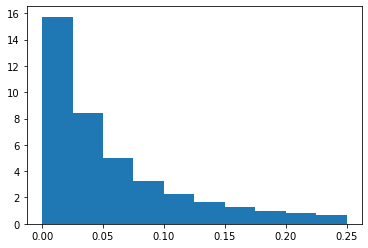

In [4]:
plt.hist(np.array(fakeNPSs).flatten(), density=1, range=(0,0.25))

In [5]:
#Save fake average images
K_x, K_y, _, _ = getFreq(imgSysData["CCDPixelSize"], imgSysData["magnification"], (100,100))
for imnum in range(100):
    fig = plt.figure(figsize=(5.5, 4.5))
    ax = fig.add_subplot(111)
    im = ax.pcolor(K_x, K_y, NPSavgs[imnum], cmap=cm.jet, vmin=0, vmax=.5)
    plt.colorbar(im)
    fig.savefig("C:\\Users\\eric0\\OneDrive\\Desktop\\Cold Physics\\fake_NPSavg_ims\\fake_NPSavg_" + str(imnum + 1))
    plt.close(fig)

<ipython-input-5-8e0697a7faaa>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(K_x, K_y, NPSavgs[imnum], cmap=cm.jet, vmin=0, vmax=.5)


In [6]:
#Save fake single-OD images
K_x, K_y, _, _ = getFreq(imgSysData["CCDPixelSize"], imgSysData["magnification"], (49,49))
for imnum in range(100):
    fig = plt.figure(figsize=(5.5, 4.5))
    ax = fig.add_subplot(111)
    im = ax.pcolor(K_x, K_y, fakeNPSs[imnum], cmap=cm.jet, vmin=0, vmax=.5)
    plt.colorbar(im)
    fig.savefig("C:\\Users\\eric0\\OneDrive\\Desktop\\Cold Physics\\fake_NPS_ims\\fake_NPS_" + str(imnum + 1))
    plt.close(fig)

<ipython-input-6-3596900aa829>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(K_x, K_y, fakeNPSs[imnum], cmap=cm.jet, vmin=0, vmax=.5)


In [7]:
#Save images and parameters
pkl.dump(NPSavgs, open(savepath + "fakeNPSavgs", "wb"))
pkl.dump(fakeNPSs, open(savepath + "fakeNPSs", "wb"))
pkl.dump(savedParas, open(savepath + "savedParas", "wb"))

In [8]:
#Delete extreme outlier images
fakeNPSs = np.array(fakeNPSs).reshape((len(fakeNPSs),-1))
savedParas = np.array(savedParas)
savedParas = np.delete(savedParas, np.where(np.amax(fakeNPSs, axis=1) > 20), 0)
fakeNPSs = np.delete(fakeNPSs, np.where(np.amax(fakeNPSs, axis=1) > 20), 0)
savedParas = np.delete(savedParas, np.where(np.amin(fakeNPSs, axis=1) < 0), 0)
fakeNPSs = np.delete(fakeNPSs, np.where(np.amin(fakeNPSs, axis=1) < 0), 0)

#Normalize images and split into training and validation data
# fakeNPSs /= 20
defocus = savedParas[:,[5]]
otherparas = np.delete(savedParas, 5, axis=1)
trainin, testin, trainout, testout, otherparasin, otherparasout = train_test_split(fakeNPSs, defocus, otherparas, test_size=0.25, shuffle=True)
for i in range(len(trainin)):
    trainin[i] -= np.mean(trainin[i])
    trainin[i] /= np.std(trainin[i])
for i in range(len(testin)):
    testin[i] -= np.mean(testin[i])
    testin[i] /= np.std(testin[i])
# trainin[trainin < 0.001] = 0.001
# testin[testin < 0.001] = 0.001
# trainin = np.log10(trainin)
# testin = np.log10(testin)
# trainin /= 3
# testin /= 3
scaler = RobustScaler(unit_variance=True)
yscaler = scaler.fit(trainout)
pkl.dump(yscaler, open(savepath + "yscaler", "wb"))
trainout = yscaler.transform(trainout)
testout = yscaler.transform(testout)

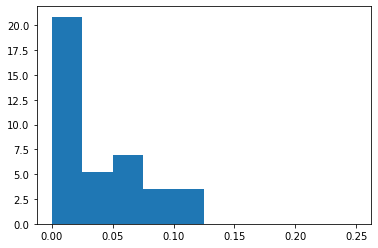

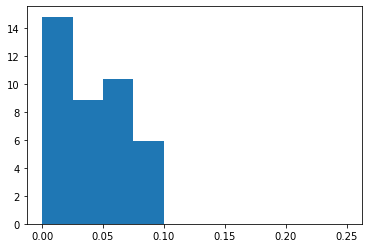

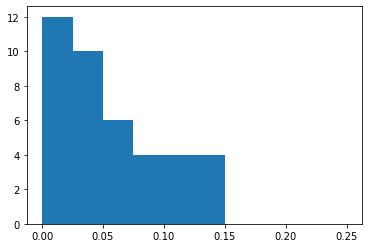

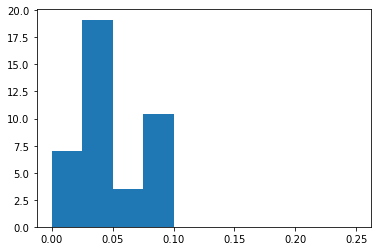

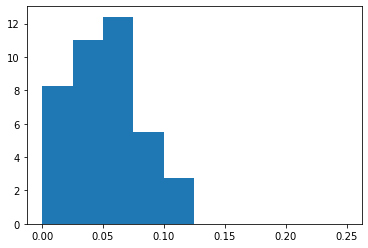

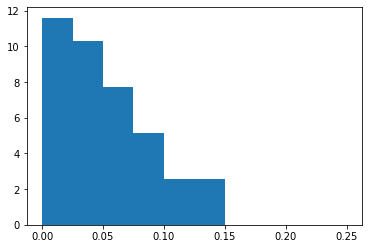

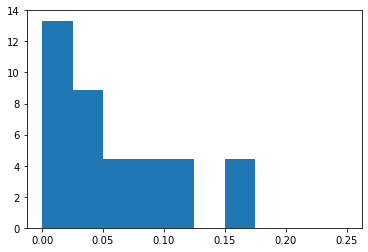

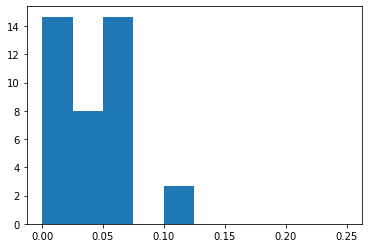

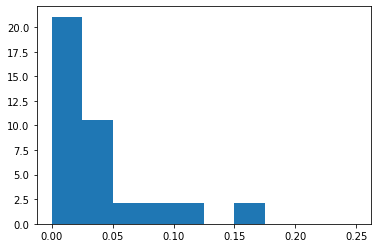

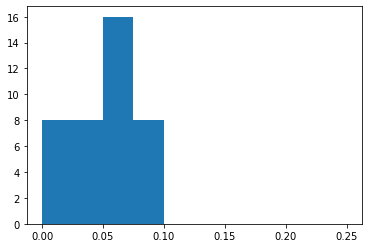

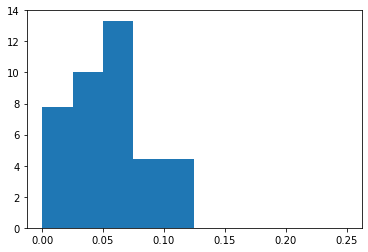

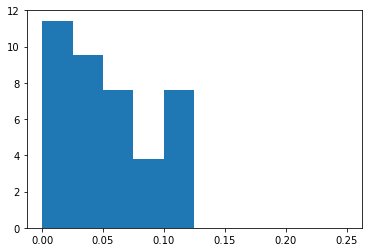

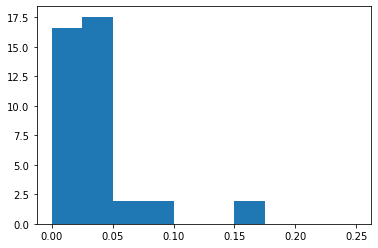

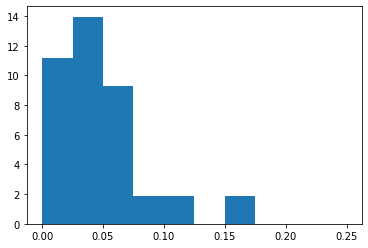

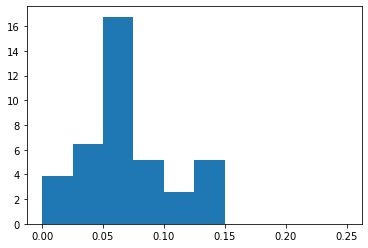

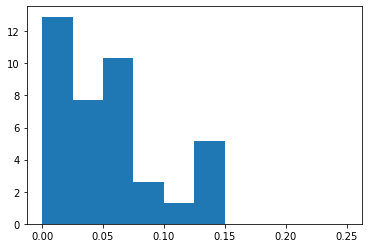

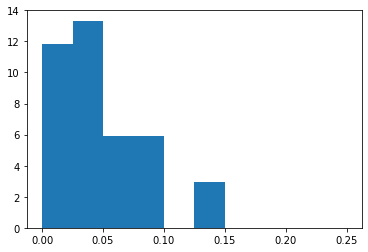

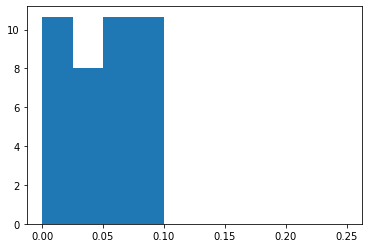

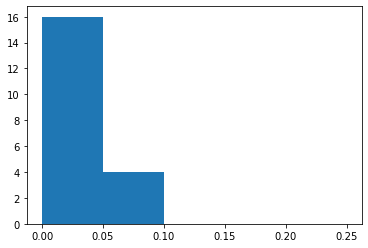

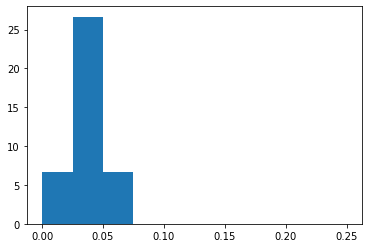

In [9]:
for image in trainin[0:20]:
    plt.hist(image.flatten(), density=1)
    plt.show()

In [10]:
#Check number of samples. Should be close to numNPSs*numParas
print(np.shape(fakeNPSs))

(49992, 2401)


In [11]:
#Convert training and validation data to tensors
trainin = tf.convert_to_tensor(trainin)
trainout = tf.convert_to_tensor(trainout)
testin = tf.convert_to_tensor(testin)
testout = tf.convert_to_tensor(testout)

In [12]:
#Store training and testing data
pkl.dump(trainin, open(savepath + "trainin", "wb"))
pkl.dump(trainout, open(savepath + "trainout", "wb"))
pkl.dump(testin, open(savepath + "testin", "wb"))
pkl.dump(testout, open(savepath + "testout", "wb"))
pkl.dump(otherparasin, open(savepath + "otherparasin", "wb"))
pkl.dump(otherparasout, open(savepath + "otherparasout", "wb"))

In [13]:
#Create images with same parameters as a real image set
NPSavgs = []
paras = []
for i in range(100):
    paras.append([0.3307113143177933, 1.0000000000000002, 0.009999999999999986, 2.4599999999999995, -1.926865182387927, 0.3640009284887366, -0.03788728477733443])
for para in paras:
    NPSavgs.append(make_M2k_Fit(para, imgSysData))
fakeNPSs = NPSavg_To_Single(NPSavgs, numNPSs)

Parameters Set: 1
Parameters Set: 2
Parameters Set: 3
Parameters Set: 4
Parameters Set: 5
Parameters Set: 6
Parameters Set: 7
Parameters Set: 8
Parameters Set: 9
Parameters Set: 10
Parameters Set: 11
Parameters Set: 12
Parameters Set: 13
Parameters Set: 14
Parameters Set: 15
Parameters Set: 16
Parameters Set: 17
Parameters Set: 18
Parameters Set: 19
Parameters Set: 20
Parameters Set: 21
Parameters Set: 22
Parameters Set: 23
Parameters Set: 24
Parameters Set: 25
Parameters Set: 26
Parameters Set: 27
Parameters Set: 28
Parameters Set: 29
Parameters Set: 30
Parameters Set: 31
Parameters Set: 32
Parameters Set: 33
Parameters Set: 34
Parameters Set: 35
Parameters Set: 36
Parameters Set: 37
Parameters Set: 38
Parameters Set: 39
Parameters Set: 40
Parameters Set: 41
Parameters Set: 42
Parameters Set: 43
Parameters Set: 44
Parameters Set: 45
Parameters Set: 46
Parameters Set: 47
Parameters Set: 48
Parameters Set: 49
Parameters Set: 50
Parameters Set: 51
Parameters Set: 52
Parameters Set: 53
Pa

In [14]:
#Save fake avg nps images with same parameters as real image set
K_x, K_y, _, _ = getFreq(imgSysData["CCDPixelSize"], imgSysData["magnification"], (100,100))
for imnum in range(100):
    fig = plt.figure(figsize=(5.5, 4.5))
    ax = fig.add_subplot(111)
    im = ax.pcolor(K_x, K_y, NPSavgs[imnum], cmap=cm.jet, vmin=0, vmax=.5)
    plt.colorbar(im)
    fig.savefig("C:\\Users\\eric0\\OneDrive\\Desktop\\Cold Physics\\fake_NPSavg_ims_SamePara\\fake_NPSavg_" + str(imnum + 1))
    plt.close(fig)

<ipython-input-14-01e993740c58>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(K_x, K_y, NPSavgs[imnum], cmap=cm.jet, vmin=0, vmax=.5)


In [15]:
#Save fake single-OD NPS images with same parameters as real image set
K_x, K_y, _, _ = getFreq(imgSysData["CCDPixelSize"], imgSysData["magnification"], (49,49))
for imnum in range(100):
    fig = plt.figure(figsize=(5.5, 4.5))
    ax = fig.add_subplot(111)
    im = ax.pcolor(K_x, K_y, fakeNPSs[imnum], cmap=cm.jet, vmin = 0, vmax=.5)
    plt.colorbar(im)
    fig.savefig("C:\\Users\\eric0\\OneDrive\\Desktop\\Cold Physics\\fake_NPS_ims_SamePara\\fake_NPS_" + str(imnum + 1))
    plt.close(fig)

<ipython-input-15-4c3d4ed5ba2f>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(K_x, K_y, fakeNPSs[imnum], cmap=cm.jet, vmin = 0, vmax=.5)


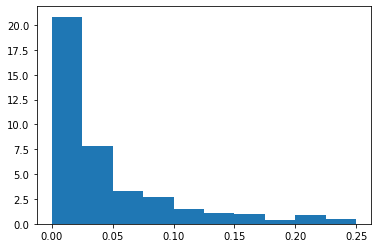

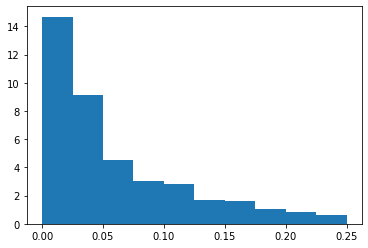

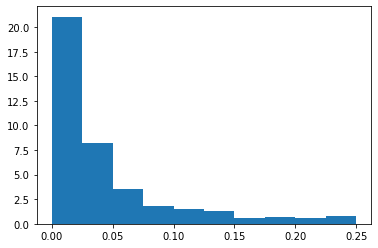

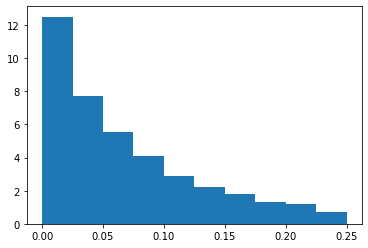

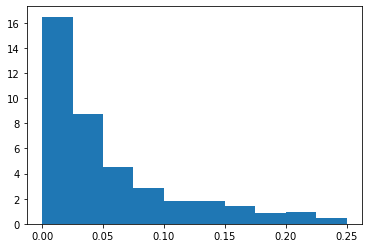

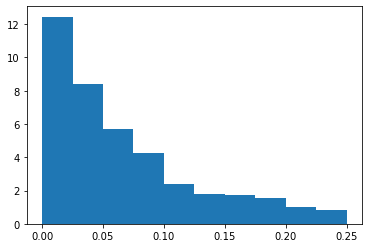

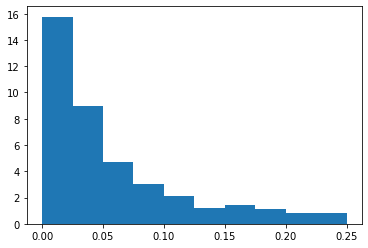

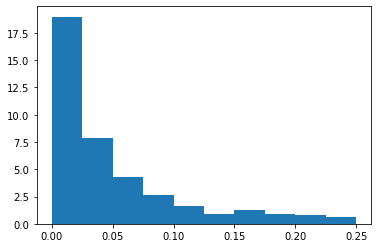

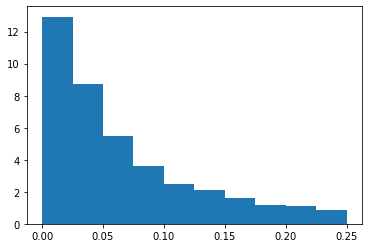

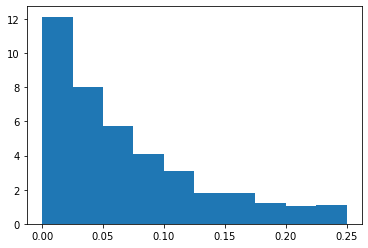

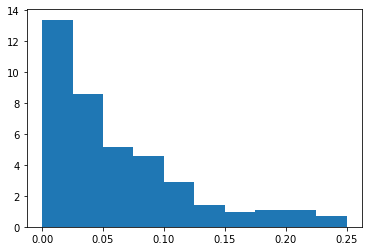

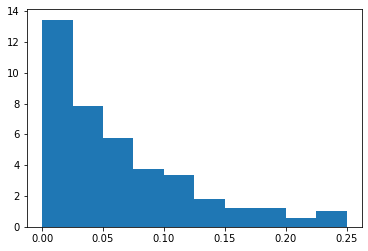

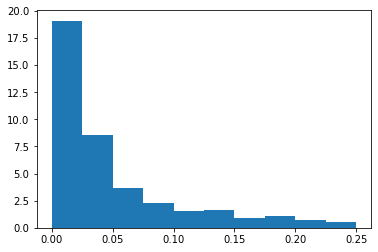

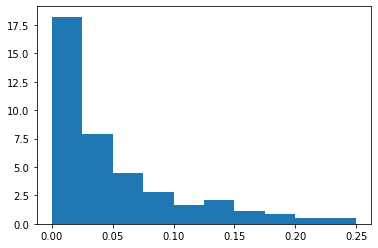

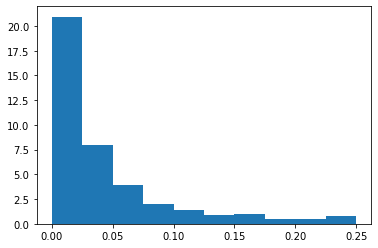

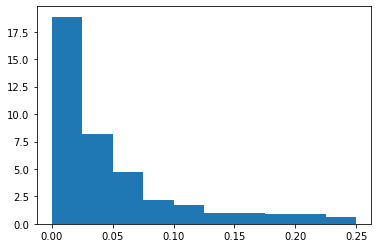

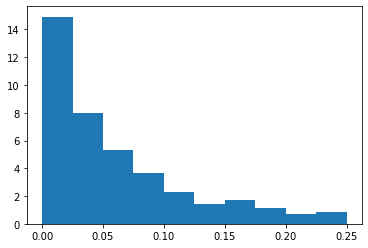

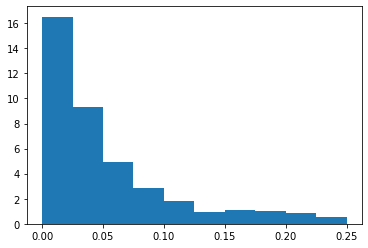

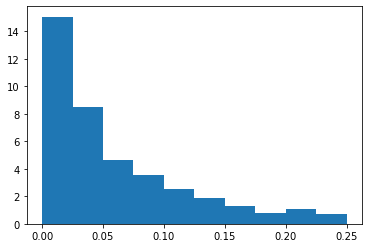

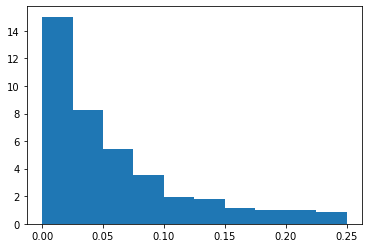

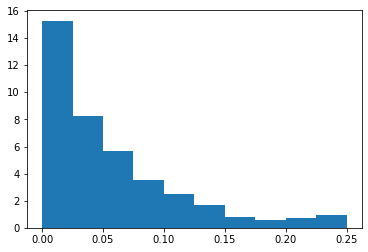

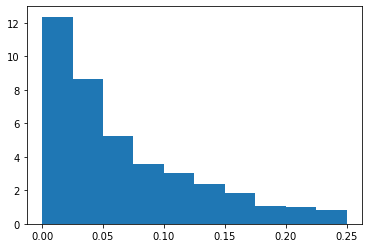

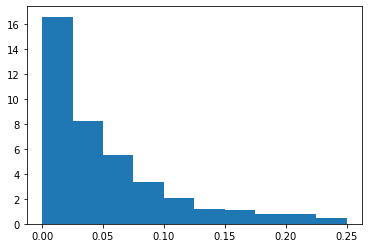

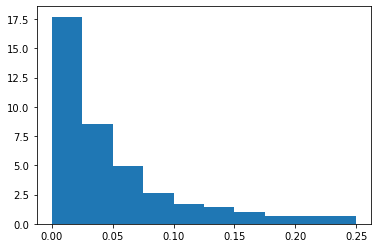

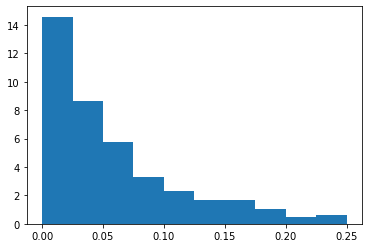

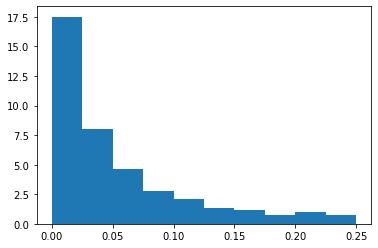

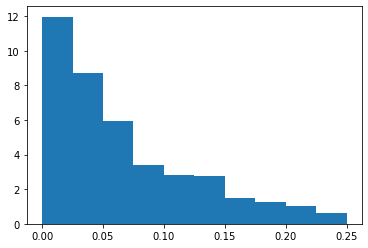

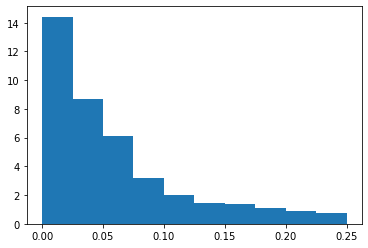

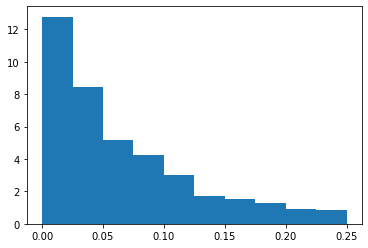

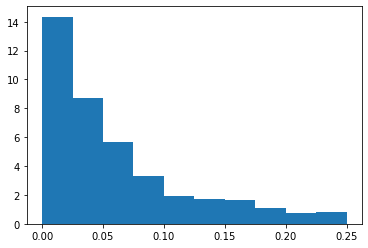

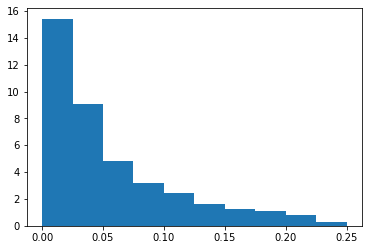

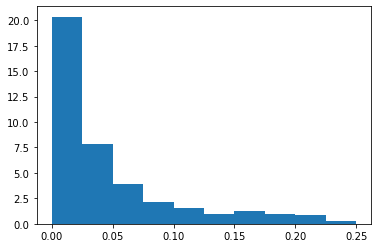

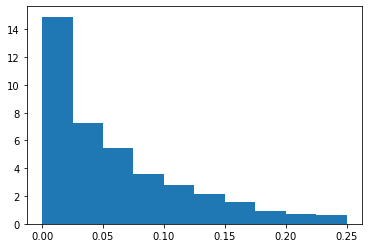

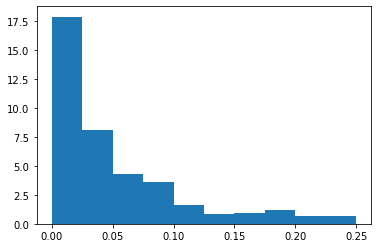

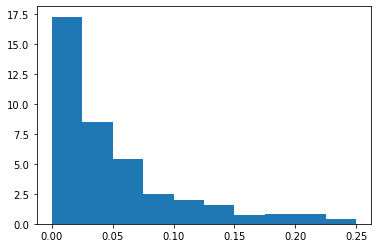

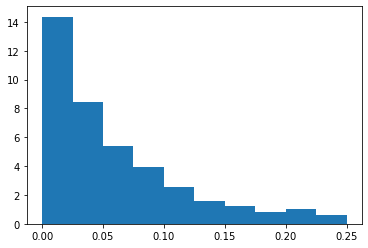

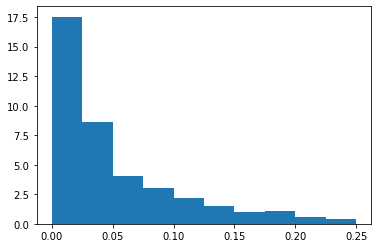

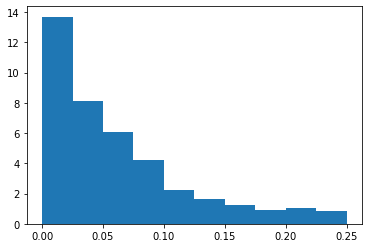

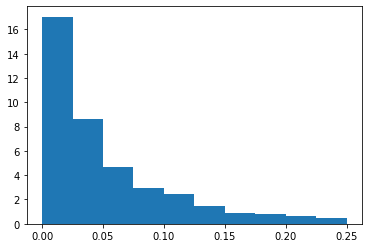

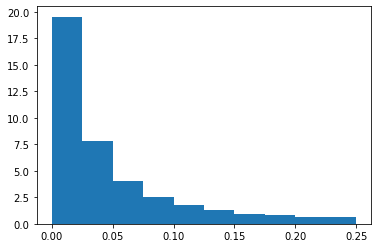

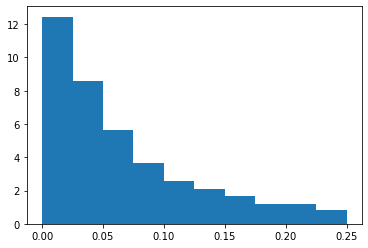

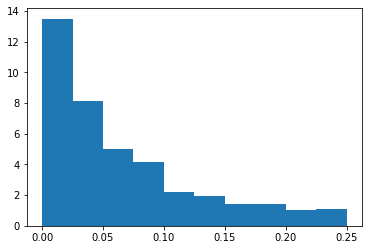

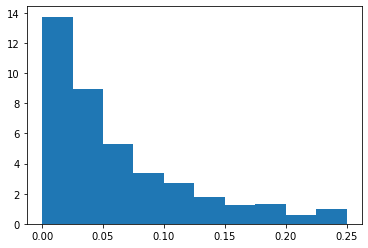

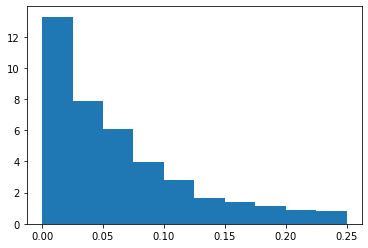

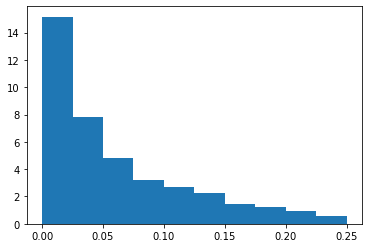

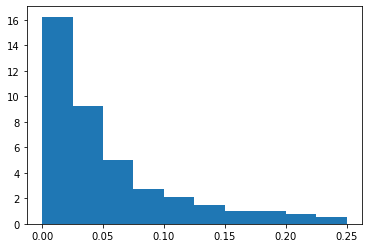

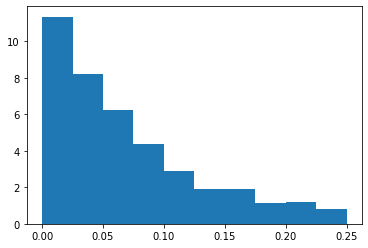

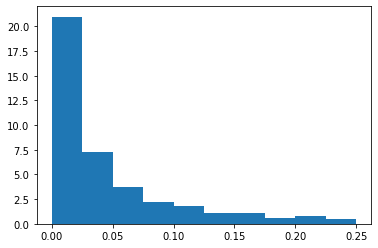

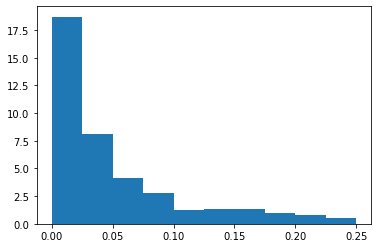

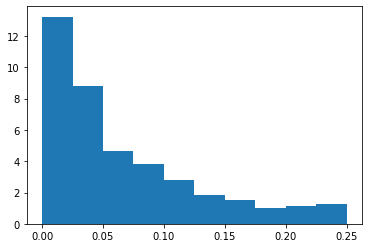

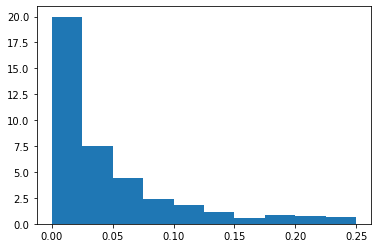

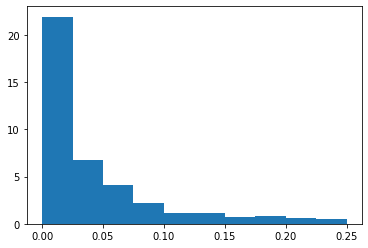

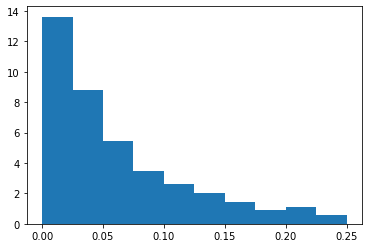

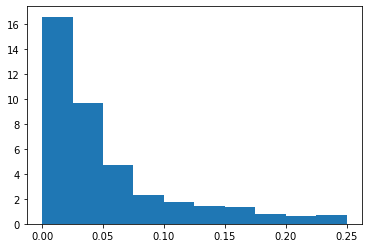

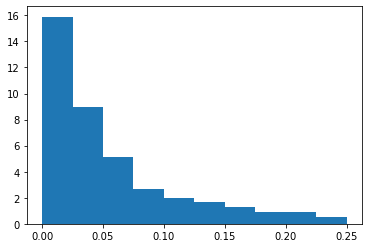

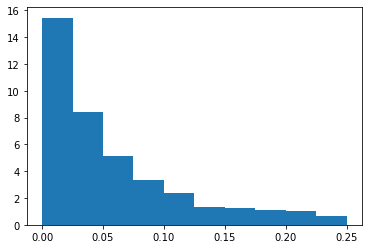

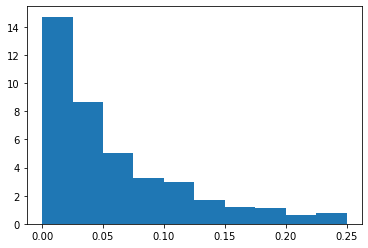

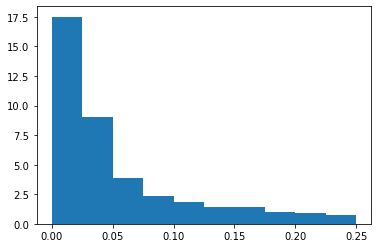

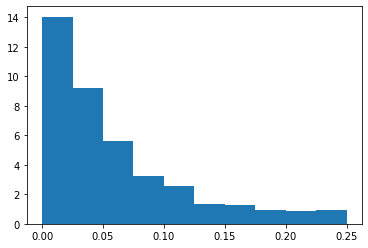

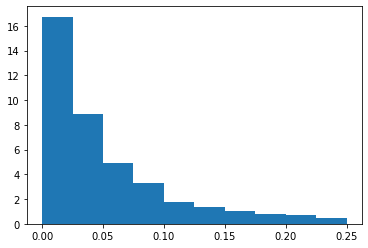

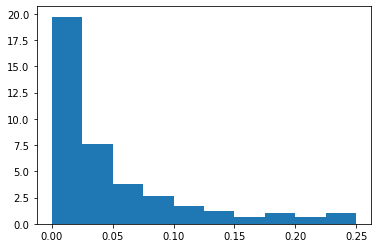

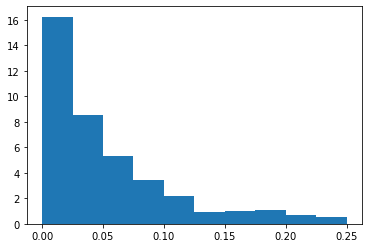

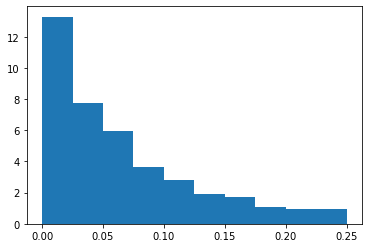

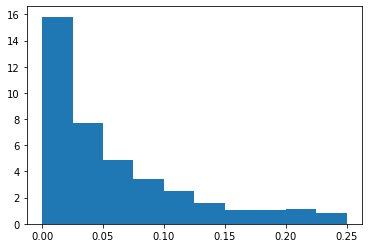

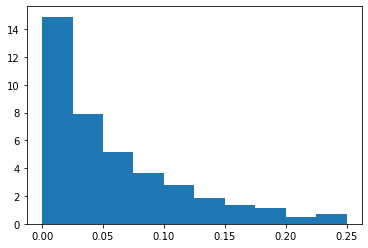

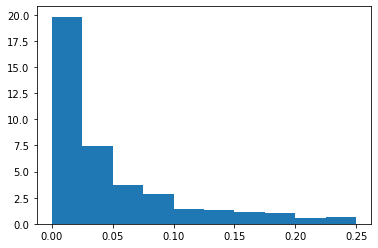

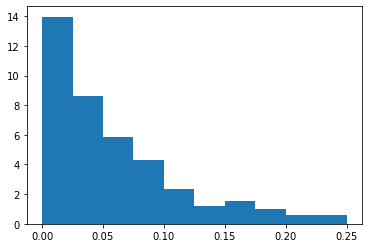

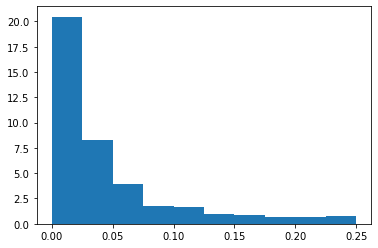

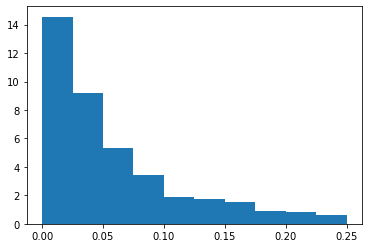

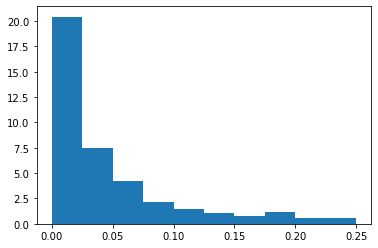

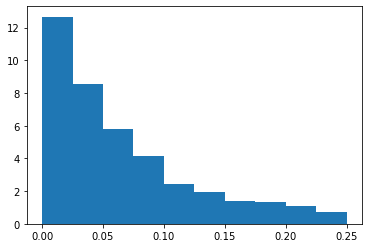

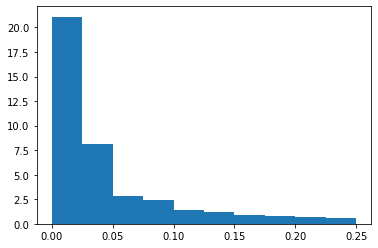

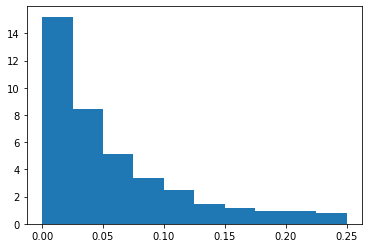

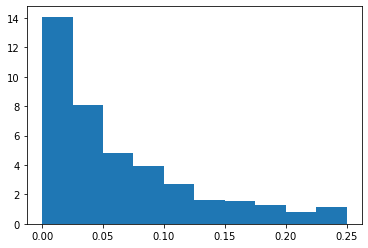

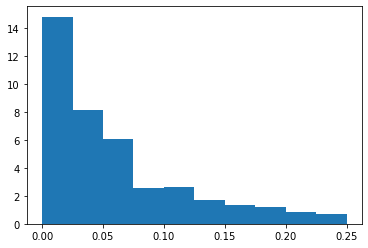

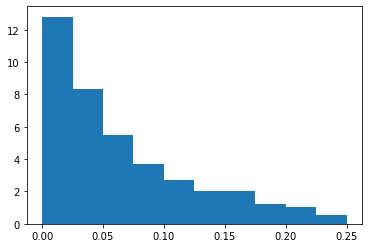

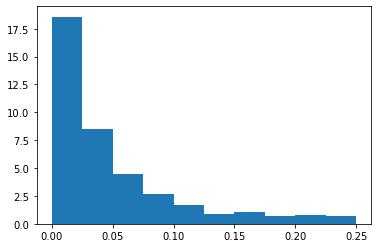

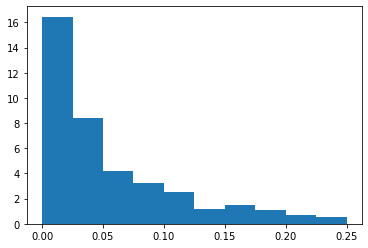

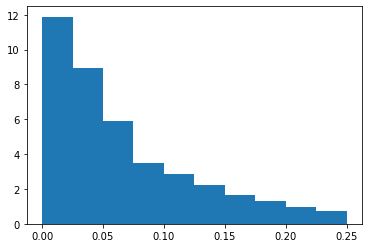

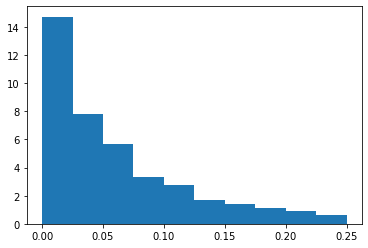

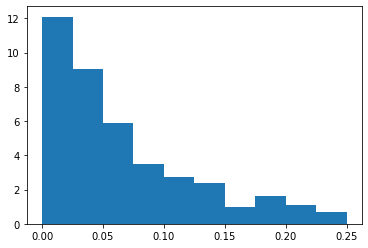

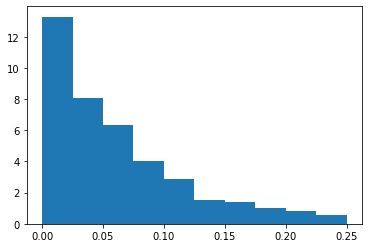

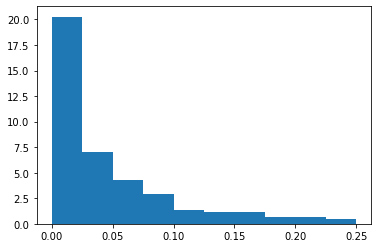

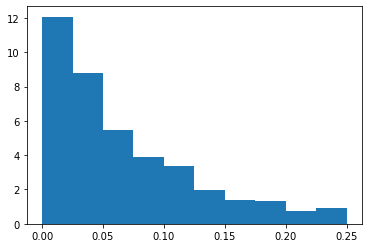

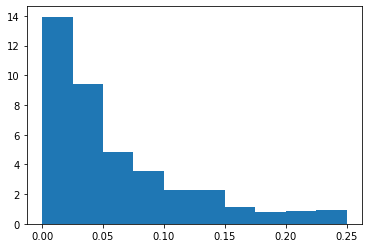

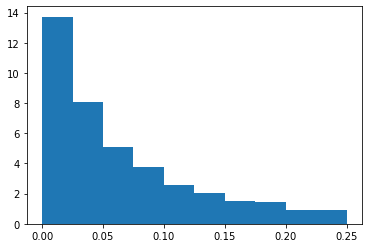

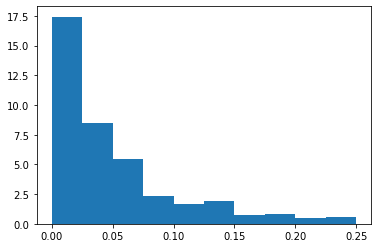

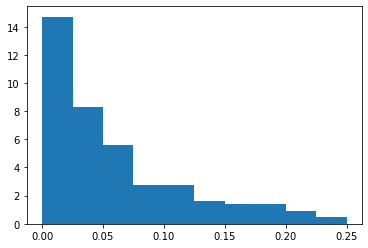

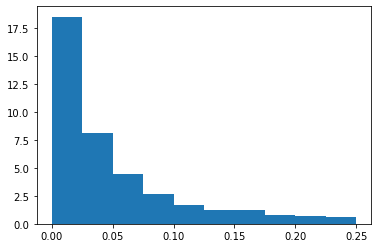

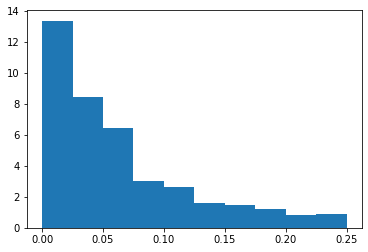

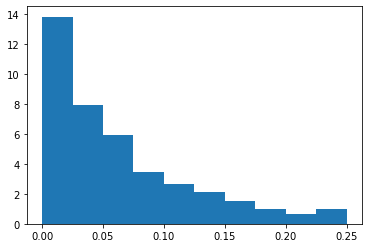

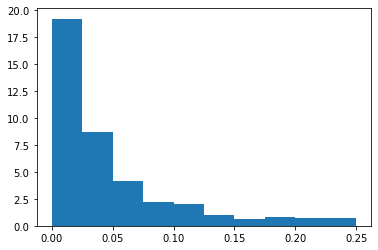

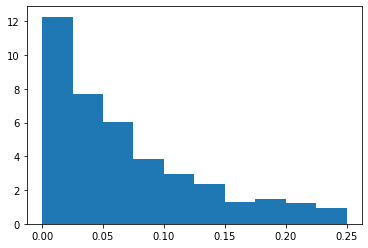

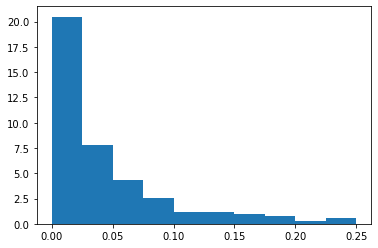

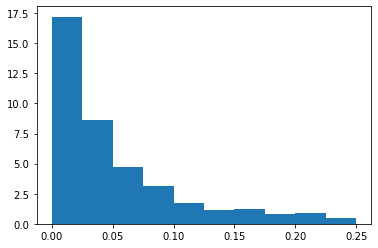

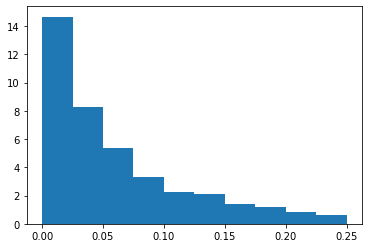

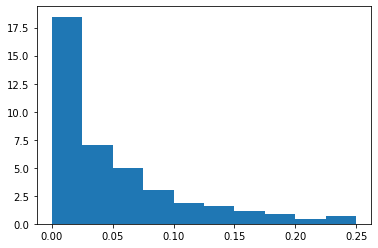

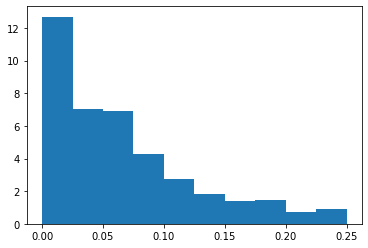

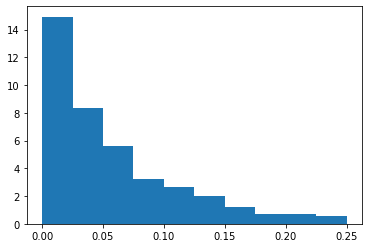

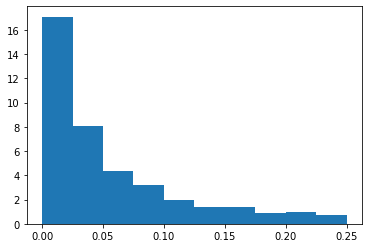

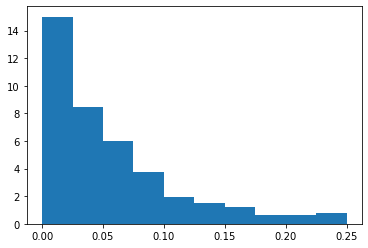

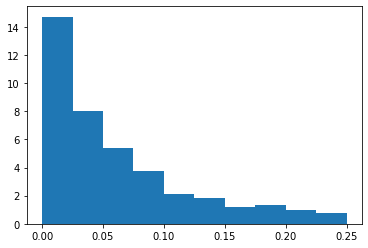

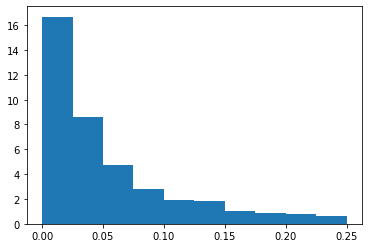

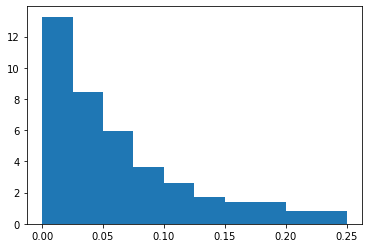

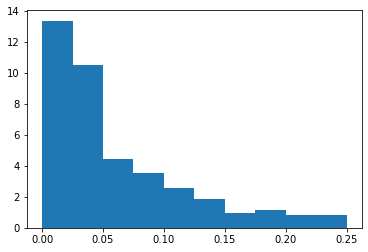

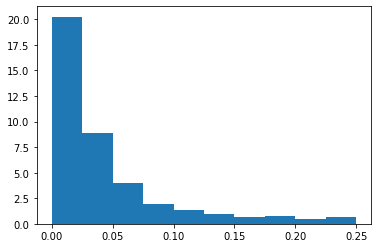

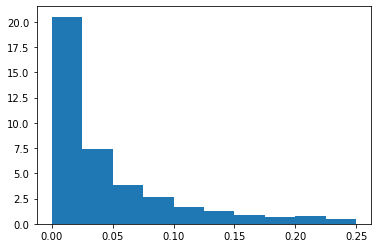

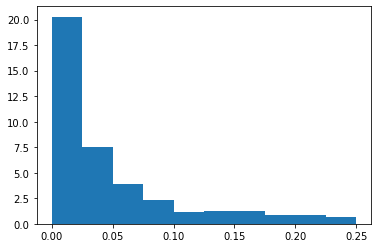

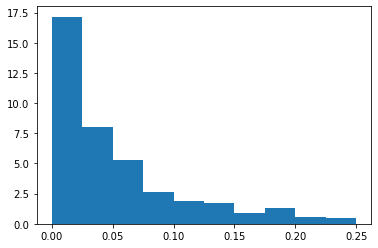

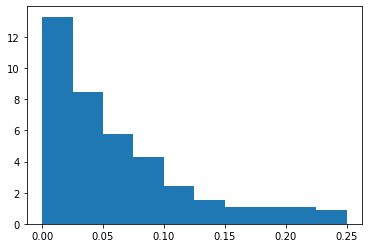

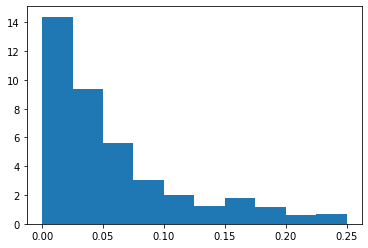

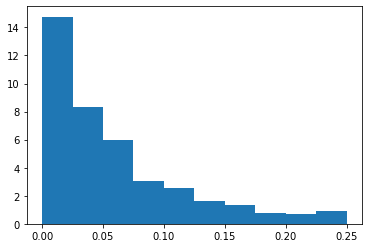

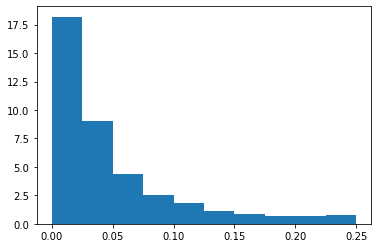

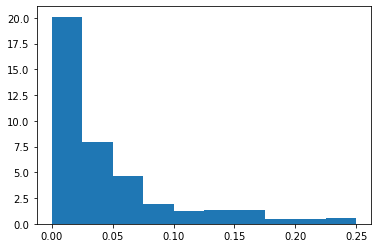

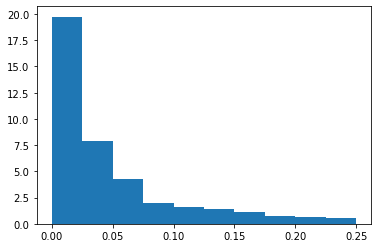

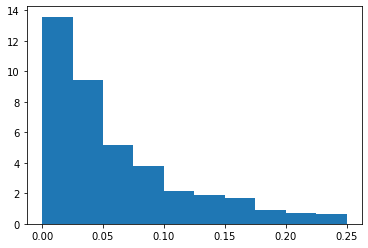

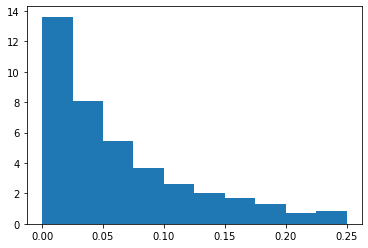

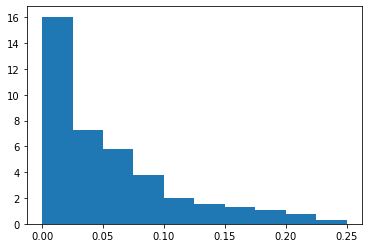

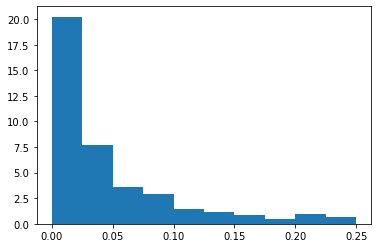

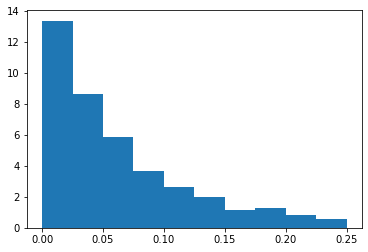

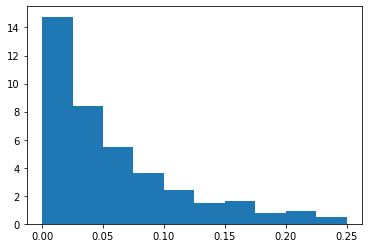

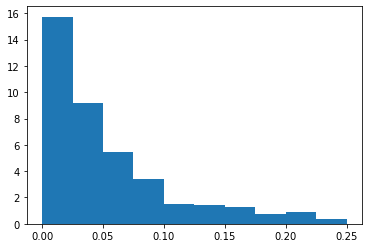

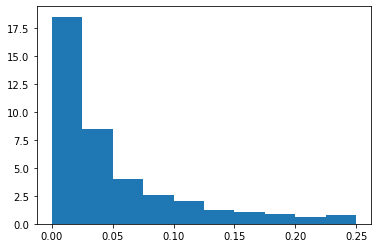

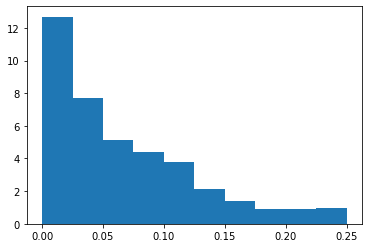

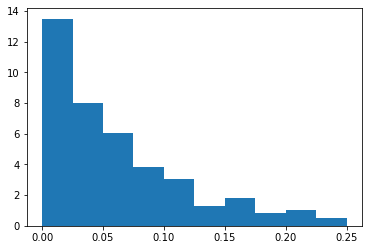

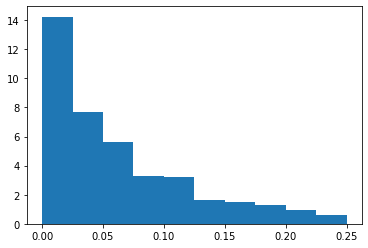

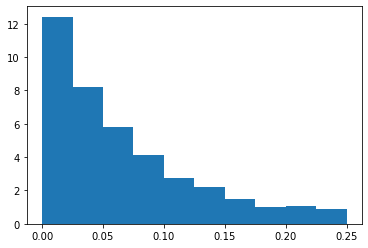

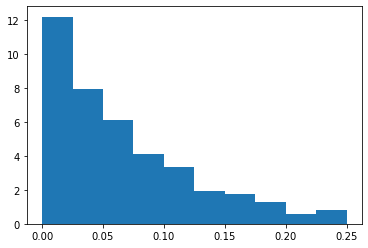

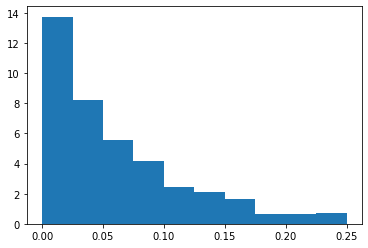

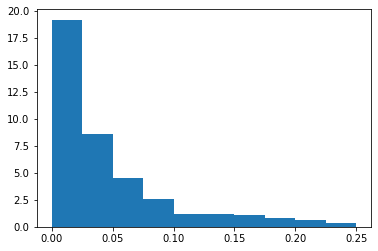

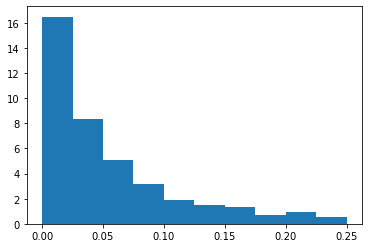

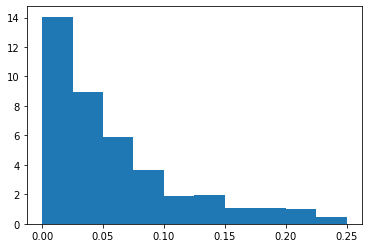

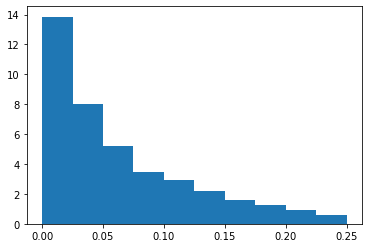

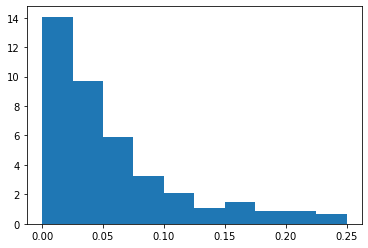

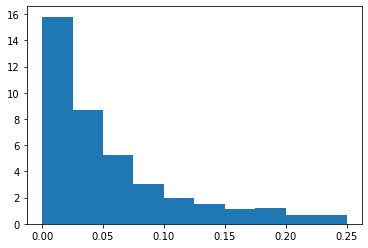

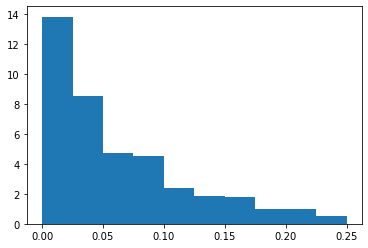

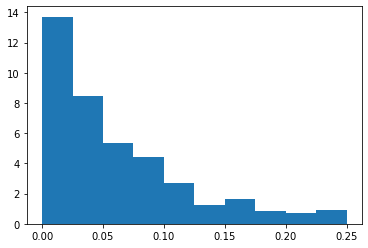

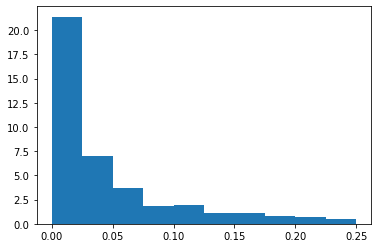

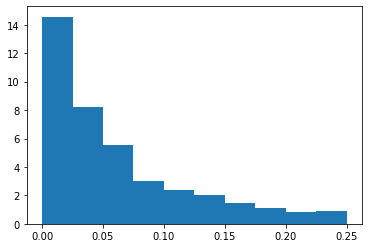

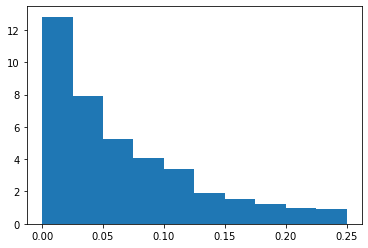

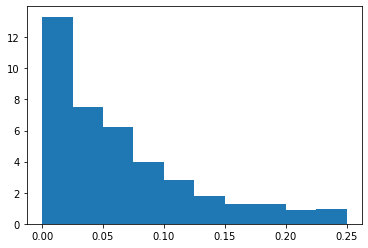

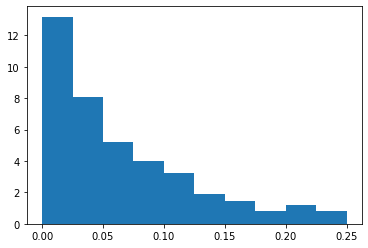

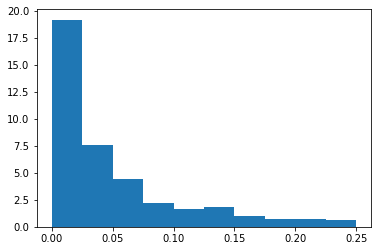

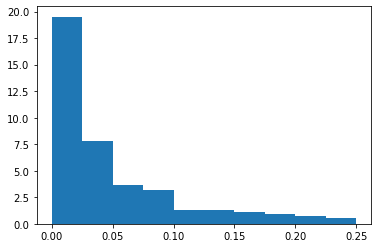

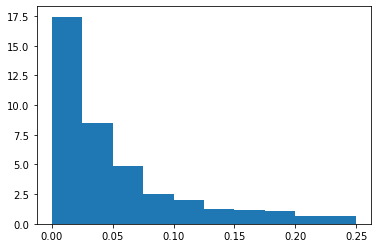

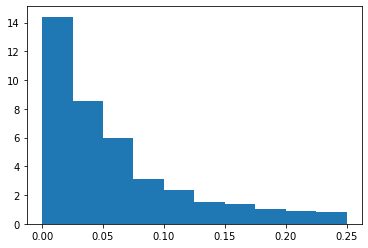

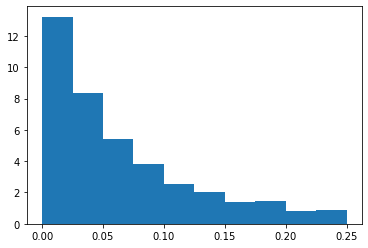

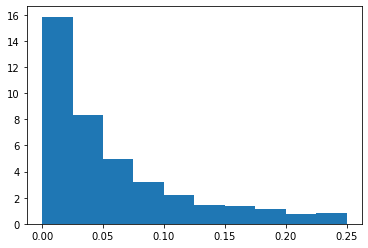

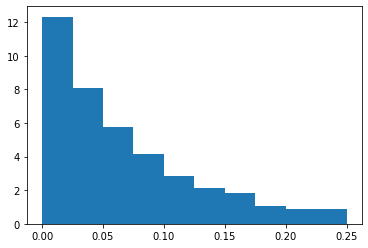

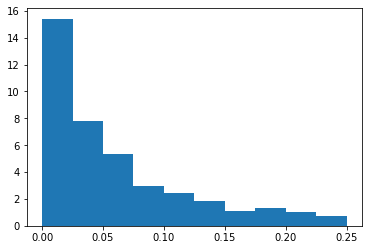

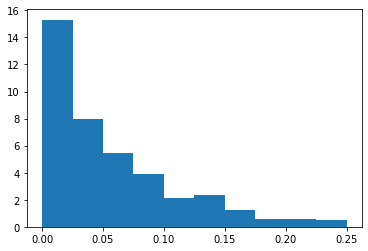

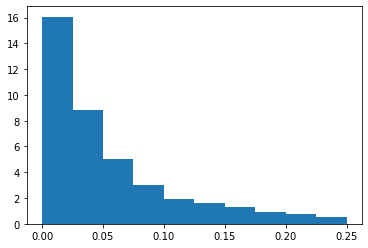

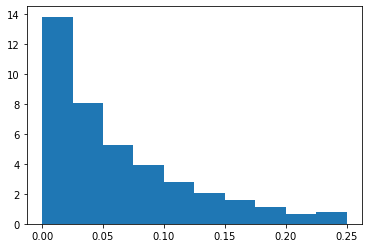

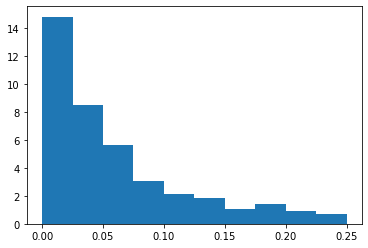

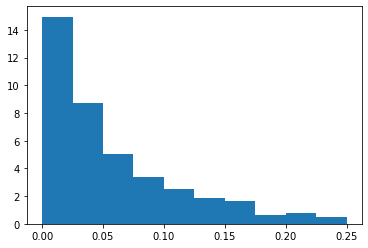

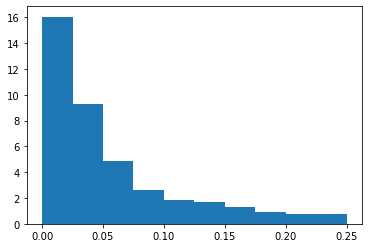

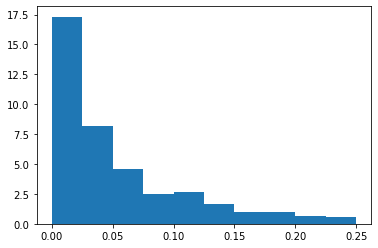

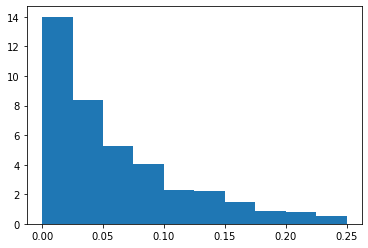

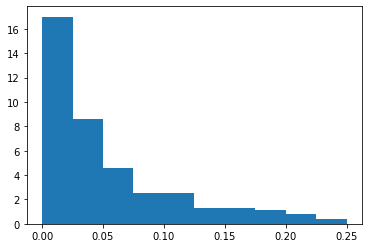

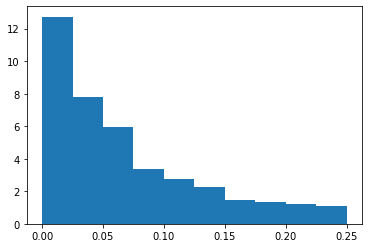

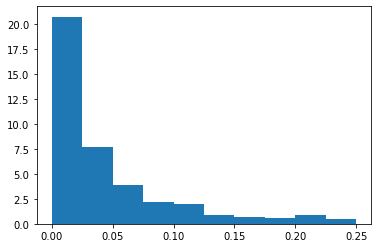

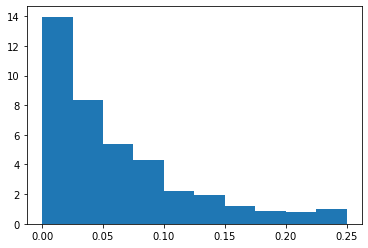

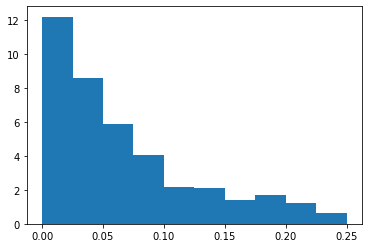

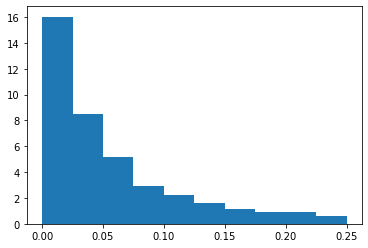

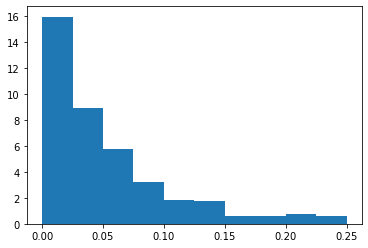

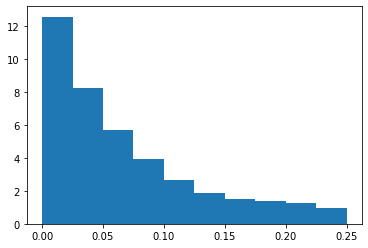

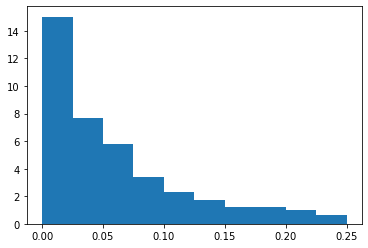

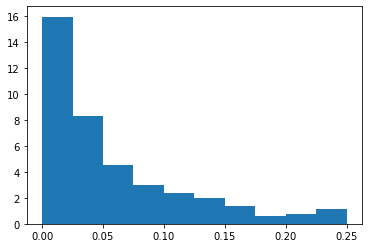

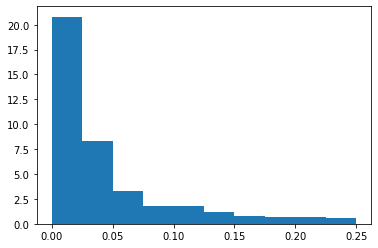

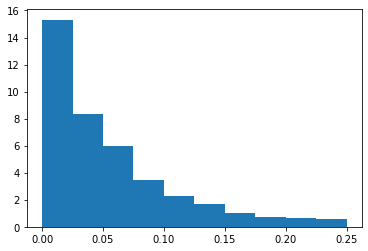

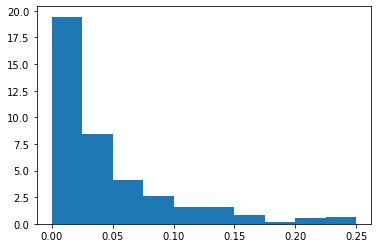

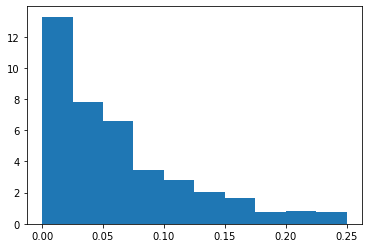

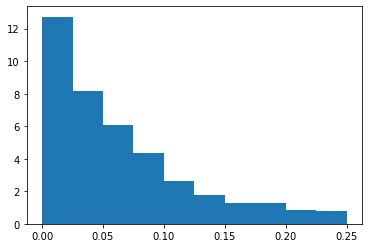

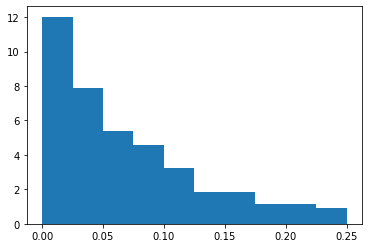

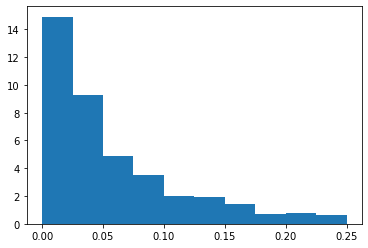

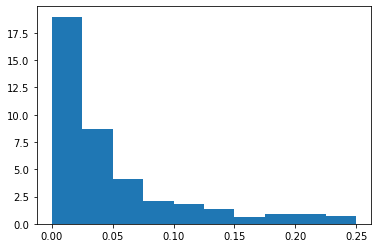

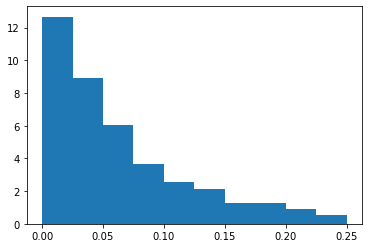

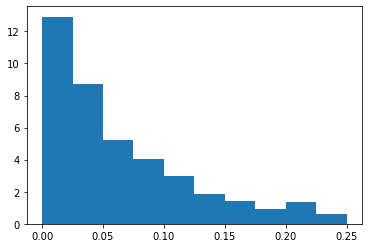

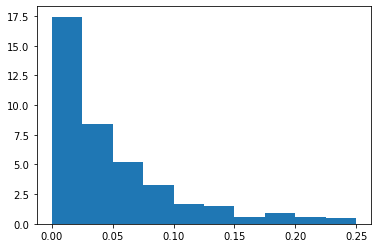

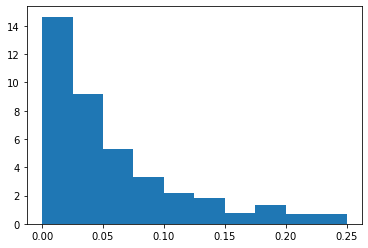

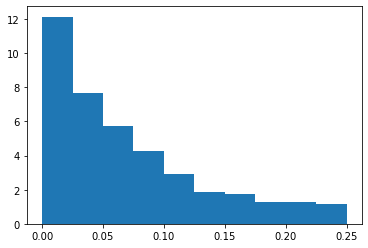

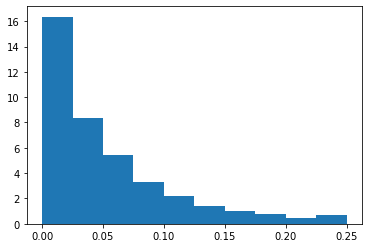

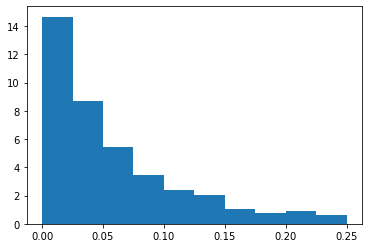

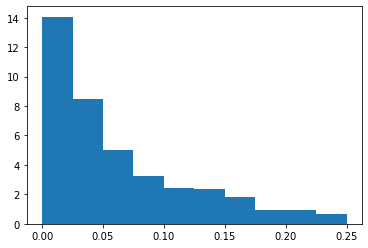

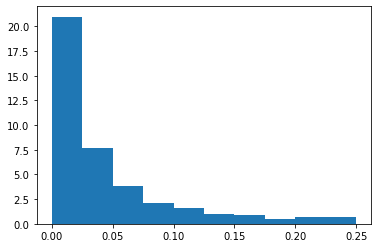

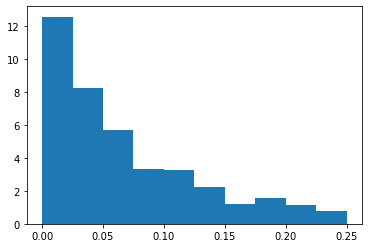

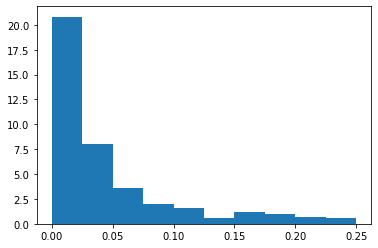

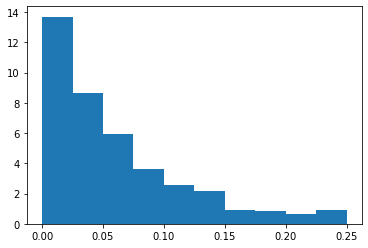

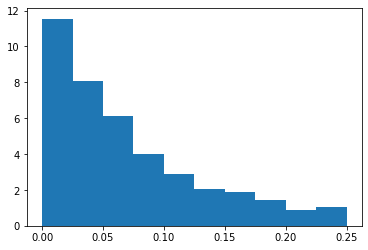

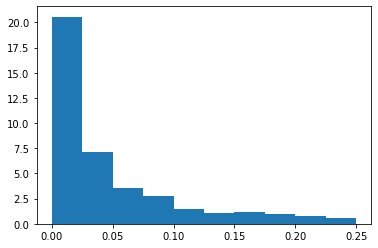

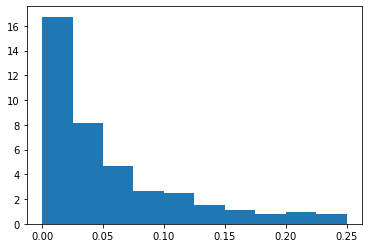

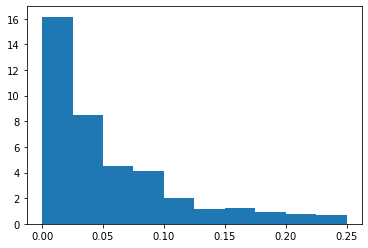

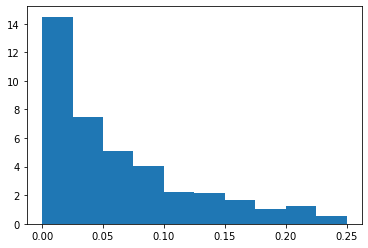

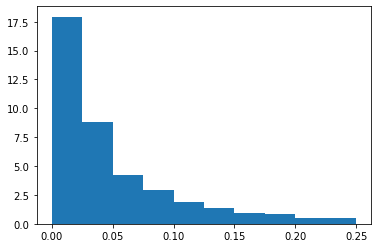

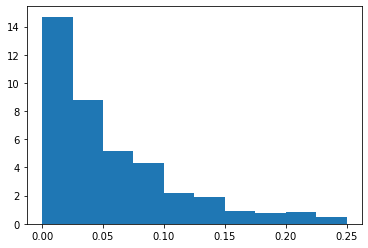

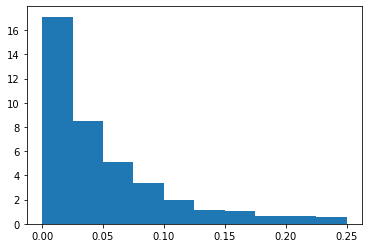

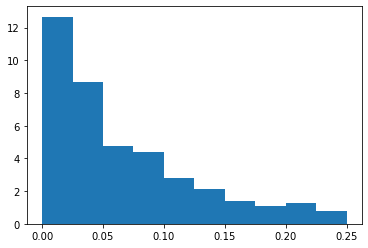

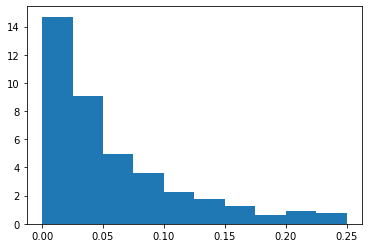

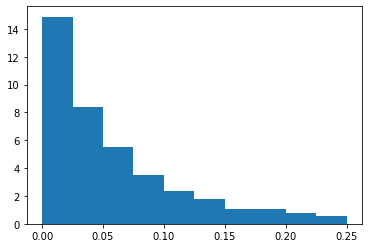

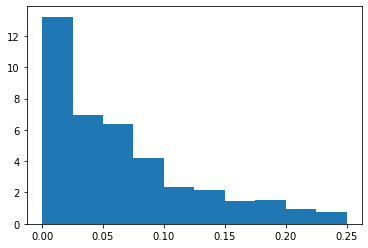

In [16]:
for fakeNPS in fakeNPSs:
    plt.hist(np.array(fakeNPS).flatten(), density=1, range=(0,0.25))
    plt.show()